<a href="https://colab.research.google.com/github/manuelescola/myprojects/blob/main/05_The_power_of_synthetic_data_predicting_hotel_cancellations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

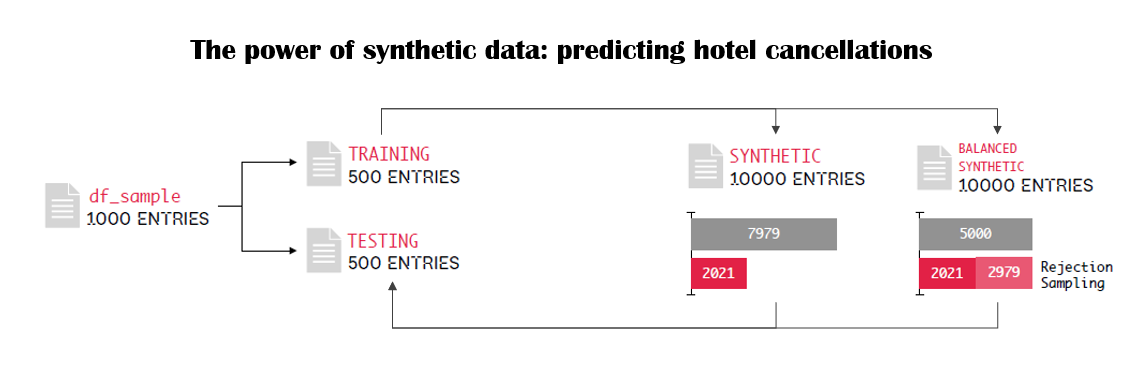

_Note: This notebook was created with private data. Please make sure you import your own dataset when running the notebook._

# 1. Introduction


**Business context: the hospitality industry**

The main revenue source in a hotel is room booking. This business model has an important particularity: its product is perishable (Hayes et al., 2011). If a room is not booked during a certain period, the revenue of that room during that time cannot be recovered later. Therefore, to maximise revenue, hotels must also maximise their occupancy rate, which can be a difficult task due to unexpected cancellations. For this reason, hotels usually recur to overbooking techniques by which they sell more rooms than the ones they have available, expecting that some of them will be cancelled.

These rooms are called overbooked rooms, and their number should be similar to the hotel's cancellations. If a hotel books more rooms than the actual number of cancellations, it can tarnish its reputation and overbooking costs are incurred. If a hotel books fewer rooms than the number of cancellations, there is a loss of revenue. Therefore, predicting the number of cancellations correctly is crucial for hotels. Different authors have explored the use of machine learning (ML) to predict cancellations (see, for example, Antonio et al., 2017).

**Synthetic data: a real business scenario**

This paper explores the use of synthetic data to enhance model performance in two ways. First, by increasing the size of the dataset and therefore train better ML models. Second, by balancing the actual arrivals and cancellations in the dataset (see Brownlee, 2019, for an explanation of why imbalanced datasets make classifiers perform worse).

The goal of the project is to test different ML algorithms before and after creating synthetic data and then provide the hotel with the model that best predicts whether a client will cancel their reservation or not. 

# 2. Setting up the notebook

In [ ]:
# Import packages
from IPython.display import Image
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from scipy.special import rel_entr
from scipy.stats import gaussian_kde
from tqdm import tqdm_notebook as tqdm
from IPython.display import display_html
from itertools import chain,cycle        
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, precision_score, recall_score, accuracy_score, f1_score
from sdv import SDV, Metadata
from sdv.tabular import GaussianCopula, CTGAN, CopulaGAN, TVAE
from sdv.lite import TabularPreset
from xgboost import XGBClassifier
import time
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sdv.sampling import Condition

# Set the seed
np.random.seed(1000)
torch.manual_seed(0)

# Creates a function to plot tables side by side
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

# Notebook configuration   
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
# Import .csv file
df_given = pd.read_csv('real_train.csv')
df_original = df_given.copy()

# 3. Theory: synthetic data considering joint distribution

When generating synthetic data, it is important to ensure that the generated data is similar to the original one in terms of its underlying statistical properties. Generating synthetic data from marginal distributions only captures the individual distributions of each variable in the data. This approach does not take into account the relationships between the variables and, as a result, the generated data may not accurately represent the original data.

To illustrate this, consider a dataset that contains information about the size of cats and dogs. If we generate synthetic data from the marginal distribution of the variables `Animal` and `Size` separately, we may end up with synthetic data that does not accurately capture the relationship between both variables in the original data, even though their marginal distributions are identical. In Figure 1, both variables follow exactly the same marginal distribution. However, we can easily see that the synthetic data does not match the original one. 

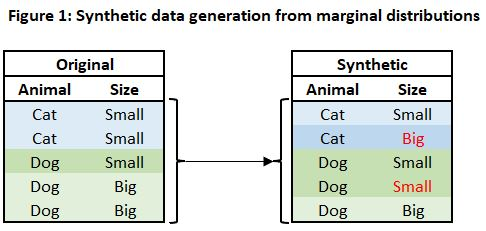

In [ ]:
Image(filename = 'Figure_1.JPG')

When using categorical data, one option to capture the joint distribution of the variables is to create a new variable which contains all the possible combinations between categories and see the frequency of each combination in the original dataset. Then, it is possible to generate new data from the marginal distribution of this new variable. Builduing on the previous example, we would get the result shown in Figure 2.

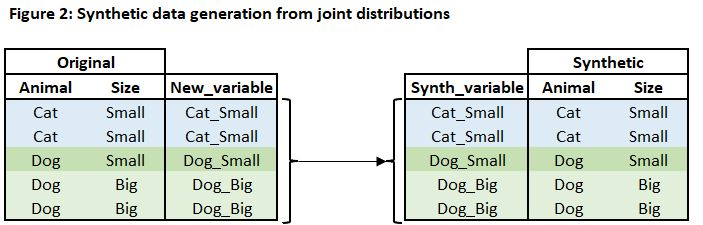

In [ ]:
Image(filename = 'Figure_2.JPG')

This approach has many limitations (for example, datasets usually contains both numeric and categorical variables). However, it illustrates the necessity to consider the joint distribution when generating synthetic data.

In the following sections, we use a library to generate synthetic data and apply it to a dataset from the hotel industry with data information.

# 4. Data preprocessing

## 4.1. Importing datasets

Three datasets will be used: <br>
1. 'HSP_noShow.csv': Dataset of customers who did not show up<br>
2. 'HSP_cancelled.csv': Dataset of customers who cancelled their booking<br>
3. 'HSP_arrival.csv': Dataset of customers who arrived to the hotel<br>

In [ ]:
# Load the Datasets
df_ns = pd.read_csv('HSP_noShow.csv', index_col=0)
df_c = pd.read_csv('HSP_cancelled.csv', index_col=0)
df_arrival = pd.read_csv('HSP_arrival.csv', index_col=0)

For data privacy reasons, we do not show here the original data (shown below). However, it is important to note that the datasets above do not contain target variable (arriving or non arriving) as they had been split on different files. It is necessary to create a target variable for each dataset.

In [ ]:
# Create the target variable
df_ns['Class'] = 'Non Arriving'
df_c['Class'] = 'Non Arriving'
df_arrival['Class'] = 'Arriving'

## 4.2. Cleaning datasets

In order to make the project more understandable, we will only use some variables from the original dataset.

In [ ]:
# Choose the important columns
usecols = ['Arrival', 'Departure', 'Country', 'Adults', 'Juniors', 'Children', 'Infants', 'Pension','Reserver', 'Total Price', 'Creation Date', 'Class']

Now we can use the previous list to filter each of the three datasets imported and combine them in just one dataset.

In [ ]:
# Combining the datasets
df_c = df_c[usecols]
df_ns = df_ns[usecols]
df_arrival = df_arrival[usecols]
print('Total rows if all of the datasets are combined:', sum([df_c.shape[0], df_ns.shape[0], df_arrival.shape[0]]))

df_combined = pd.concat([df_arrival, df_ns, df_c])
df_combined.reset_index(drop=True, inplace=True)
print(f'The combined dataset has {df_combined.shape[0]} rows and {df_combined.shape[1]} columns')
df_combined.head()

Total rows if all of the datasets are combined: 13079
The combined dataset has 13079 rows and 12 columns


,Arrival,Departure,Country,Adults,Juniors,Children,Infants,Pension,Reserver,Total Price,Creation Date,Class
0,23/02/2022,27/02/2022,ESP,2,0,0,0,SA,"BRAVONEXT, S.A.",228.00,04/05/2021,Arriving
1,04/03/2022,06/03/2022,ESP,2,0,0,0,HD,BOOKING.COM B.V.,175.96,17/06/2021,Arriving
2,04/03/2022,06/03/2022,ESP,2,0,0,0,HD,BOOKING.COM B.V.,175.96,17/06/2021,Arriving
3,04/03/2022,06/03/2022,ESP,2,0,0,0,HD,BOOKING.COM B.V.,175.96,17/06/2021,Arriving
4,04/03/2022,06/03/2022,ESP,2,0,0,0,HD,BOOKING.COM B.V.,175.96,17/06/2021,Arriving


In [ ]:
# Calculate the number of instances for each class
df_combined['Class'].value_counts()

Arriving        9523
Non Arriving    3556
Name: Class, dtype: int64

In [ ]:
# Check the datatype for each columns
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13079 entries, 0 to 13078
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Arrival        13079 non-null  object 
 1   Departure      13079 non-null  object 
 2   Country        10227 non-null  object 
 3   Adults         13079 non-null  int64  
 4   Juniors        13079 non-null  int64  
 5   Children       13079 non-null  int64  
 6   Infants        13079 non-null  int64  
 7   Pension        13079 non-null  object 
 8   Reserver       11934 non-null  object 
 9   Total Price    13079 non-null  float64
 10  Creation Date  13079 non-null  object 
 11  Class          13079 non-null  object 
dtypes: float64(1), int64(4), object(7)
memory usage: 1.2+ MB


Aside from `Arrival`, `Departure`, and `Creation Date` which would be converted into datetime format, the categorical columns `Country` and `Pension` have to be checked whether they contain a lot of different categories or not.

In [ ]:
for col in ['Country', 'Pension', 'Reserver']:
    print(f'The number of unique categories on column {col} is {df_combined[col].nunique()}')

The number of unique categories on column Country is 68
The number of unique categories on column Pension is 5
The number of unique categories on column Reserver is 370


**Treatment of Categorical Columns - Country**

The same approach will be used to treat column `Country`, which is to keep the top 10 countries based on occurences and group the rest as 'Other'.

In [ ]:
# Create a list of top 10 countries
countries = list(df_combined['Country'].value_counts().index[:10])
countries

['ESP', 'DEU', 'GBR', 'ITA', 'FRA', 'MRT', 'NLD', 'SWE', 'IRL', 'MAR']

In [ ]:
# Update the country names based on the new definition
df_combined['Country'] = df_combined['Country'].apply(lambda x: x if x in countries else 'Other')
df_combined

,Arrival,Departure,Country,Adults,Juniors,Children,Infants,Pension,Reserver,Total Price,Creation Date,Class
0,23/02/2022,27/02/2022,ESP,2,0,0,0,SA,"BRAVONEXT, S.A.",228.00,04/05/2021,Arriving
1,04/03/2022,06/03/2022,ESP,2,0,0,0,HD,BOOKING.COM B.V.,175.96,17/06/2021,Arriving
2,04/03/2022,06/03/2022,ESP,2,0,0,0,HD,BOOKING.COM B.V.,175.96,17/06/2021,Arriving
3,04/03/2022,06/03/2022,ESP,2,0,0,0,HD,BOOKING.COM B.V.,175.96,17/06/2021,Arriving
4,04/03/2022,06/03/2022,ESP,2,0,0,0,HD,BOOKING.COM B.V.,175.96,17/06/2021,Arriving
...,...,...,...,...,...,...,...,...,...,...,...,...
13074,20/03/2022,23/03/2022,DEU,2,0,0,0,HD,BOOKING.COM B.V.,555.05,18/03/2022,Non Arriving
13075,10/08/2022,17/08/2022,Other,2,0,0,0,HD,BOOKING.COM B.V.,1032.00,29/06/2022,Non Arriving
13076,22/10/2022,24/10/2022,ESP,2,0,0,0,HD,Internal,161.10,31/08/2022,Non Arriving
13077,07/10/2022,09/10/2022,ESP,2,0,0,0,HD,BOOKING.COM B.V.,227.80,09/07/2022,Non Arriving


In [ ]:
df_combined['Country'].value_counts()

ESP      8138
Other    3552
DEU       325
GBR       271
ITA       219
FRA       156
MRT       128
NLD        79
SWE        73
IRL        72
MAR        66
Name: Country, dtype: int64

The column `Country` has been successfully updated.

**Feature Engineering**

On their own, the columns `Arrival`, `Departure`, and `Creation Date` would not provide useful information. However, they could be used to create new features: <br>
1. Stay Duration: The duration which the customer stayed based on the difference of Departure Date and Arrival Date <br>
2. Book Duration: The duration based on the difference of Arrival Date and Creation Date <br>

In [ ]:
# Change the data type into date time format
df_combined['Arrival'] = pd.to_datetime(df_combined['Arrival'], format='%d/%m/%Y')
df_combined['Departure'] = pd.to_datetime(df_combined['Departure'], format='%d/%m/%Y')
df_combined['Creation Date'] = pd.to_datetime(df_combined['Creation Date'], format='%d/%m/%Y')

In [ ]:
# Create new columns
df_combined['Stay Duration'] = (df_combined['Departure'] - df_combined['Arrival']).dt.days
df_combined['Book Duration'] = (df_combined['Arrival'] - df_combined['Creation Date']).dt.days

# Some of the reservations have book duration lower than zero. This happened whenever a customer extended their current on-going booking.
df_combined = df_combined[df_combined['Book Duration'] >= 0]

In [ ]:
df_combined.head()

,Arrival,Departure,Country,Adults,Juniors,Children,Infants,Pension,Reserver,Total Price,Creation Date,Class,Stay Duration,Book Duration
0,2022-02-23,2022-02-27,ESP,2,0,0,0,SA,"BRAVONEXT, S.A.",228.00,2021-05-04,Arriving,4,295
1,2022-03-04,2022-03-06,ESP,2,0,0,0,HD,BOOKING.COM B.V.,175.96,2021-06-17,Arriving,2,260
2,2022-03-04,2022-03-06,ESP,2,0,0,0,HD,BOOKING.COM B.V.,175.96,2021-06-17,Arriving,2,260
3,2022-03-04,2022-03-06,ESP,2,0,0,0,HD,BOOKING.COM B.V.,175.96,2021-06-17,Arriving,2,260
4,2022-03-04,2022-03-06,ESP,2,0,0,0,HD,BOOKING.COM B.V.,175.96,2021-06-17,Arriving,2,260


In [ ]:
df_combined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 13036 entries, 0 to 13078
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Arrival        13036 non-null  datetime64[ns]
 1   Departure      13036 non-null  datetime64[ns]
 2   Country        13036 non-null  object        
 3   Adults         13036 non-null  int64         
 4   Juniors        13036 non-null  int64         
 5   Children       13036 non-null  int64         
 6   Infants        13036 non-null  int64         
 7   Pension        13036 non-null  object        
 8   Reserver       13036 non-null  object        
 9   Total Price    13036 non-null  float64       
 10  Creation Date  13036 non-null  datetime64[ns]
 11  Class          13036 non-null  object        
 12  Stay Duration  13036 non-null  int64         
 13  Book Duration  13036 non-null  int64         
dtypes: datetime64[ns](3), float64(1), int64(6), object(4)
memory usage: 1.

Another feature that will be created is `Non Adults` to aggregate the `Juniors`, `Children`, and `Infants` columns. This is because these columns have zero values for most of the time.

In [ ]:
# Non Adults
non_adults = ['Juniors', 'Children','Infants']
for col in non_adults:
    print(df_combined[col].value_counts())

0    13036
Name: Juniors, dtype: int64
0    12885
1      150
2        1
Name: Children, dtype: int64
0    13028
1        8
Name: Infants, dtype: int64


In [ ]:
# Aggregate the Juniors, Children, and Infants columns
df_combined['Non Adults'] = df_combined.apply(lambda x: x[non_adults].sum(), axis=1)
df_combined = df_combined[df_combined.columns[~pd.Series(df_combined.columns).isin(non_adults)]]
df_combined.head()

/tmp/ipykernel_159540/2132003244.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_combined['Non Adults'] = df_combined.apply(lambda x: x[non_adults].sum(), axis=1)


,Arrival,Departure,Country,Adults,Pension,Reserver,Total Price,Creation Date,Class,Stay Duration,Book Duration,Non Adults
0,2022-02-23,2022-02-27,ESP,2,SA,"BRAVONEXT, S.A.",228.00,2021-05-04,Arriving,4,295,0
1,2022-03-04,2022-03-06,ESP,2,HD,BOOKING.COM B.V.,175.96,2021-06-17,Arriving,2,260,0
2,2022-03-04,2022-03-06,ESP,2,HD,BOOKING.COM B.V.,175.96,2021-06-17,Arriving,2,260,0
3,2022-03-04,2022-03-06,ESP,2,HD,BOOKING.COM B.V.,175.96,2021-06-17,Arriving,2,260,0
4,2022-03-04,2022-03-06,ESP,2,HD,BOOKING.COM B.V.,175.96,2021-06-17,Arriving,2,260,0


In [ ]:
df_combined['Adults'].value_counts()

1    6842
2    6151
3      43
Name: Adults, dtype: int64

In [ ]:
df_combined['Non Adults'].value_counts()

0    12878
1      156
2        2
Name: Non Adults, dtype: int64

In [ ]:
df_combined.shape

(13036, 12)

In [ ]:
# Remove date columns
date_cols = ['Arrival','Departure','Creation Date']
df_combined = df_combined[df_combined.columns[~pd.Series(df_combined.columns).isin(date_cols)]]
df_combined.shape

(13036, 9)

## 4.3. Sampling 1000 instances

The dataset cleaned above contains thousand of instances. However, in this project we want to show how synthetic data can improve model performance by increasing the amount of data available when little data is avaiblable. Therefore, here we take a sample of just 1000 instances which will be used to generate the synthetic data and train the models.

In [ ]:
# Copy the dataset into a new dataframe
df_sample = df_combined.sample(1000, random_state = 42).copy()

# Rename the target variable values to 0 and 1
class_dict = {'Arriving': 0,
             'Non Arriving': 1}
df_sample['Class'] = df_sample['Class'].map(class_dict)                                       
print(df_sample.shape)
df_sample.head()

(1000, 9)


,Country,Adults,Pension,Reserver,Total Price,Class,Stay Duration,Book Duration,Non Adults
812,ESP,1,SA,BOOKING.COM B.V.,147.90,0,2,45,0
8146,Other,2,HD,BOOKING.COM B.V.,148.41,0,1,0,0
10460,Other,2,HD,TRAVELSCAPE/EXPEDIA,128.52,1,1,134,0
10368,ESP,1,HD,Internal,82.45,1,1,3,0
12632,ESP,1,HD,"NAFTILIAKI POSEIDON, S.L.",284.16,1,2,1,0


In [ ]:
# Check the distribution of the sampled records
df_sample['Class'].value_counts()

0    748
1    252
Name: Class, dtype: int64

In [ ]:
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 812 to 7713
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Country        1000 non-null   object 
 1   Adults         1000 non-null   int64  
 2   Pension        1000 non-null   object 
 3   Reserver       1000 non-null   object 
 4   Total Price    1000 non-null   float64
 5   Class          1000 non-null   int64  
 6   Stay Duration  1000 non-null   int64  
 7   Book Duration  1000 non-null   int64  
 8   Non Adults     1000 non-null   int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 78.1+ KB


## 4.4. Plotting the variables

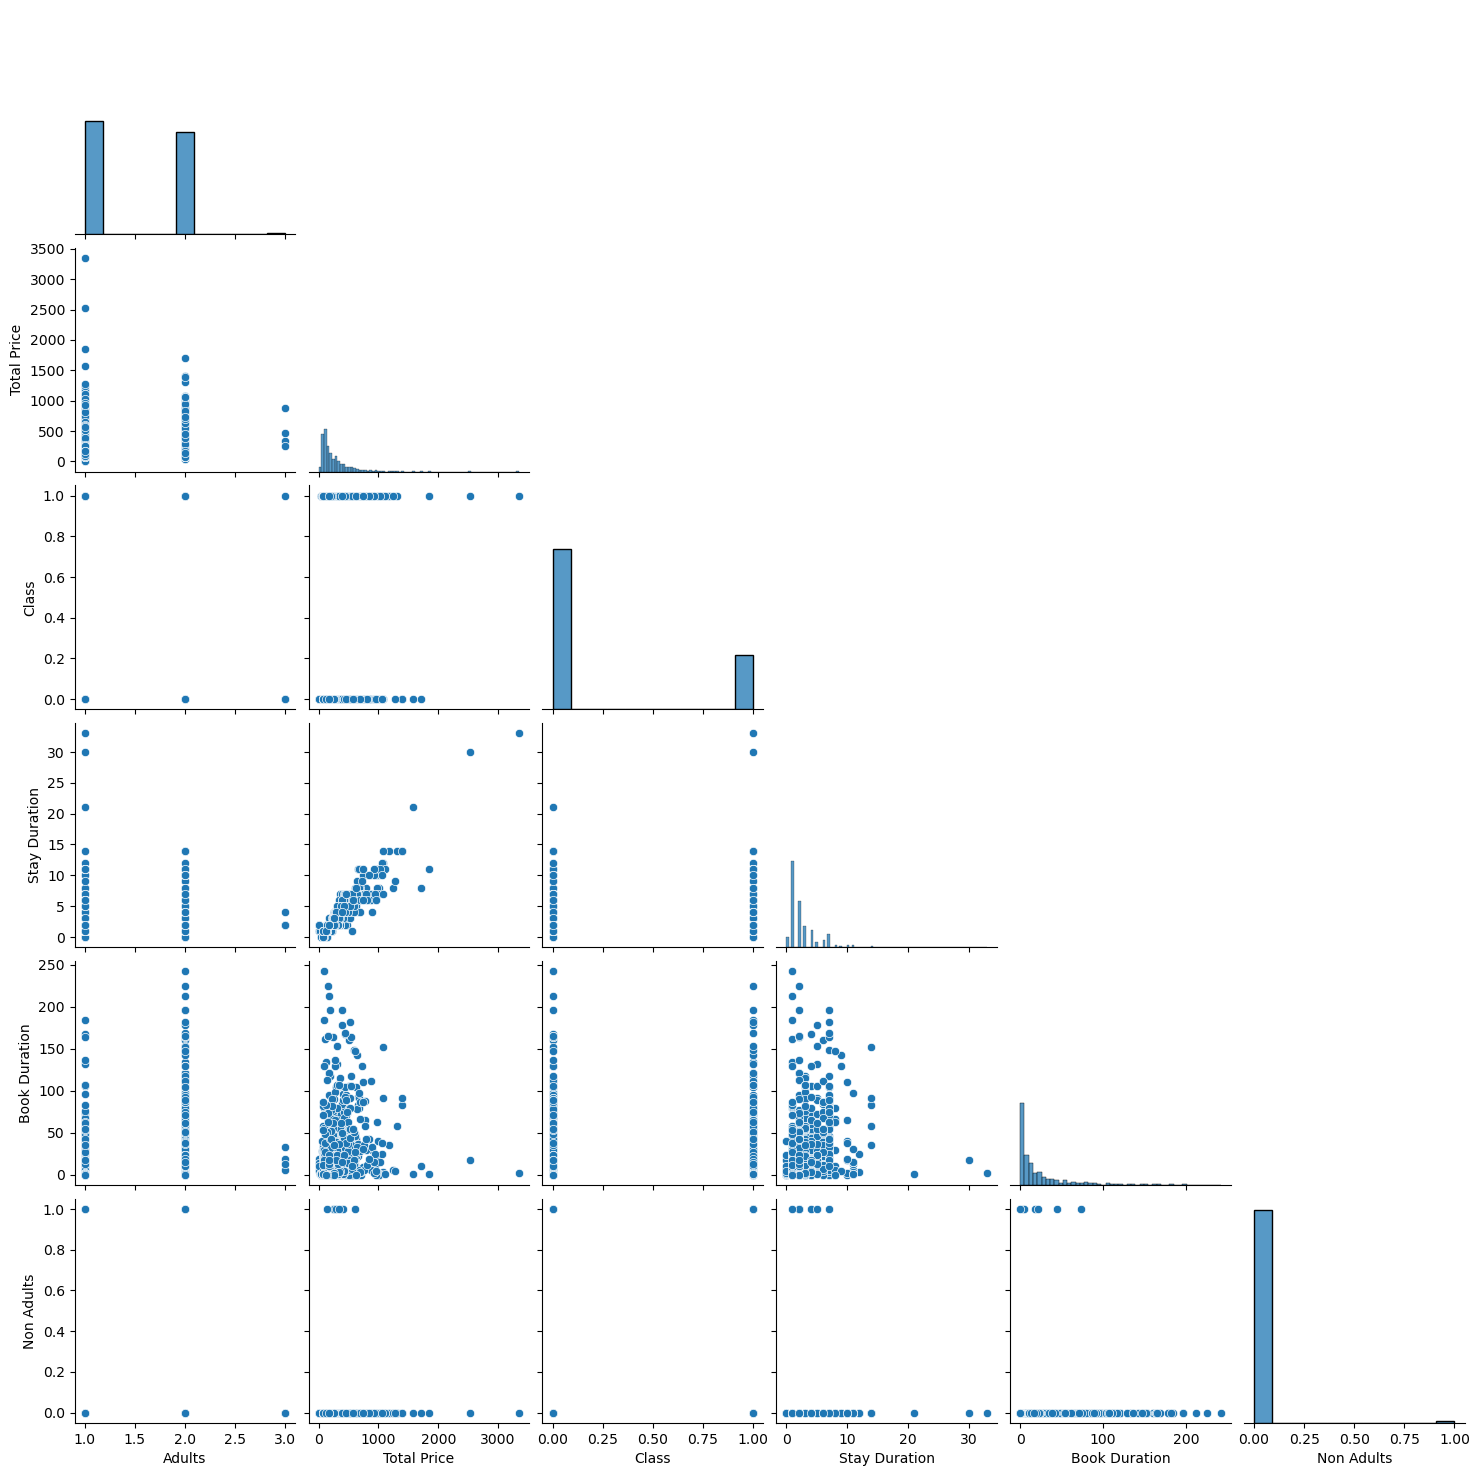

In [ ]:
# Create a pairplot from the sampled data
sns.pairplot(df_sample, corner=True)
plt.show()

# 5. Generating synthetic data with CTGAN

The function to generate synthetic data will be based on a CTGAN (Conditional Tabular GAN) model, which is a method to model the distribution from a tabular data and to sample the observations from the learned distribution by using GAN approach (Xu et al., 2019). CTGAN is able to address the challenges of modelling continuous and discrete features, continuous features which have multi-modal non-gaussian values, and categorical features which have severe imbalance. The model will be trained using a mini-batch size of 50 to update the parameters more frequently and to help on escaping local minima.

In [ ]:
def fit_synthetic(data):
    """Fit synthetic model data generation using CTGAN()"""
    synthetic_model = CTGAN(batch_size=50)
    synthetic_model.fit(data)
    return synthetic_model

## 5.1. Generate 1000  rows of synthetic data

In [ ]:
# set seed for synthetic data generation
np.random.seed(42)
torch.manual_seed(42)
synthetic_model = fit_synthetic(df_sample)

In [ ]:
# Sample 1000 rows using the function from Q6
df_synthetic_1000 = synthetic_model.sample(num_rows=1000)

In [ ]:
print(df_synthetic_1000.shape, df_sample.shape)
df_synthetic_1000.head()

(1000, 9) (1000, 9)


,Country,Adults,Pension,Reserver,Total Price,Class,Stay Duration,Book Duration,Non Adults
0,Other,2,HD,BOOKING.COM B.V.,1006.89,1,6,80,0
1,Other,2,HD,BOOKING.COM B.V.,1570.99,1,6,126,0
2,Other,1,HD,"HOTELBEDS PRODUCT, SLU",129.04,0,2,38,0
3,Other,1,GPC,BOOKING.COM B.V.,249.06,1,12,9,0
4,ESP,1,HD,"NAFTILIAKI POSEIDON, S.L.",208.71,0,2,24,0


In [ ]:
sample_counts

0    748
1    252
Name: Class, dtype: int64

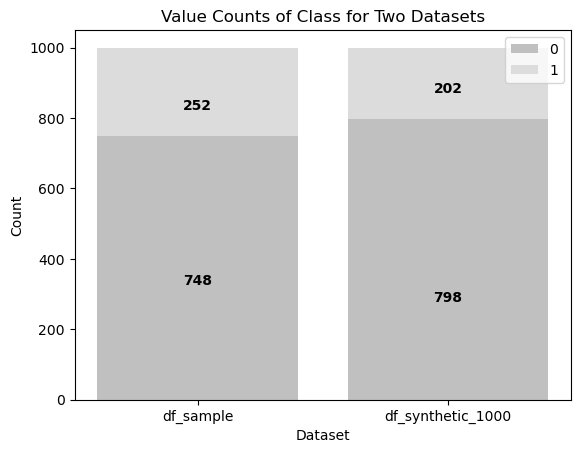

In [ ]:
# Compute the value counts of 'Class' for each dataset
sample_counts = df_sample['Class'].value_counts()
synthetic_counts = df_synthetic_1000['Class'].value_counts()

# Get the value counts for each category of 'Class'
sample_0_count = sample_counts[0]
sample_1_count = sample_counts[1]
synthetic_0_count = synthetic_counts[0]
synthetic_1_count = synthetic_counts[1]

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(['df_sample', 'df_synthetic_1000'], [sample_0_count, synthetic_0_count], label='0', color='silver', )
ax.bar(['df_sample', 'df_synthetic_1000'], [sample_1_count, synthetic_1_count], bottom=[sample_0_count, synthetic_0_count], label='1', color='gainsboro', )

# Add value count labels for each category
for i, v in enumerate([sample_0_count, sample_1_count, synthetic_0_count, synthetic_1_count]):
    ax.text(i//2, 1000 - v + 75, str(v), ha='center', fontweight='bold')

# Add axis labels and legend
ax.set_xlabel('Dataset')
ax.set_ylabel('Count')
ax.set_title('Value Counts of Class for Two Datasets')
ax.legend()
plt.show()

In [ ]:
display('Class composition of original data', df_sample['Class'].value_counts())
display('Class composition of synthetic data', df_synthetic_1000['Class'].value_counts())

'Class composition of original data'

0    748
1    252
Name: Class, dtype: int64

'Class composition of synthetic data'

0    798
1    202
Name: Class, dtype: int64

## 5.2. Original vs. synthetic data characteristics

### 5.2.1. Marginal distribution comparison: original vs. synthetic data

In [ ]:
df_synthetic_1000.head()

,Country,Adults,Pension,Reserver,Total Price,Class,Stay Duration,Book Duration,Non Adults
0,Other,2,HD,BOOKING.COM B.V.,1006.89,1,6,80,0
1,Other,2,HD,BOOKING.COM B.V.,1570.99,1,6,126,0
2,Other,1,HD,"HOTELBEDS PRODUCT, SLU",129.04,0,2,38,0
3,Other,1,GPC,BOOKING.COM B.V.,249.06,1,12,9,0
4,ESP,1,HD,"NAFTILIAKI POSEIDON, S.L.",208.71,0,2,24,0


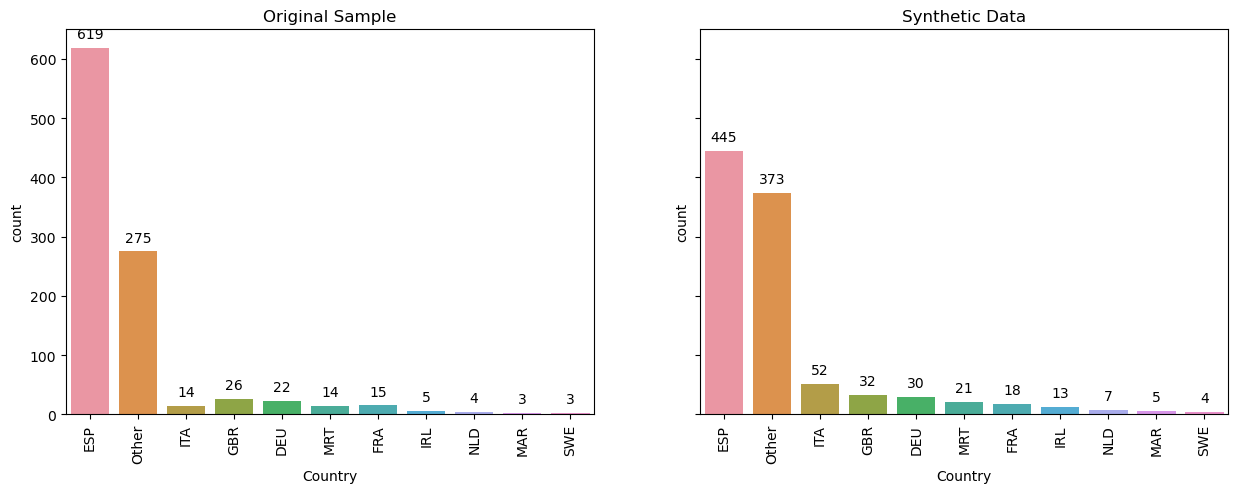

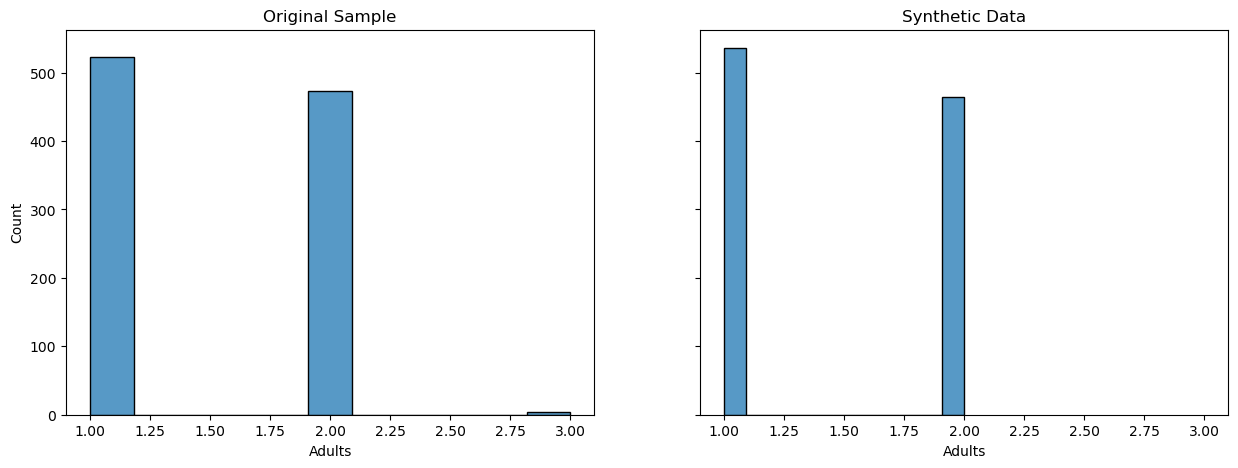

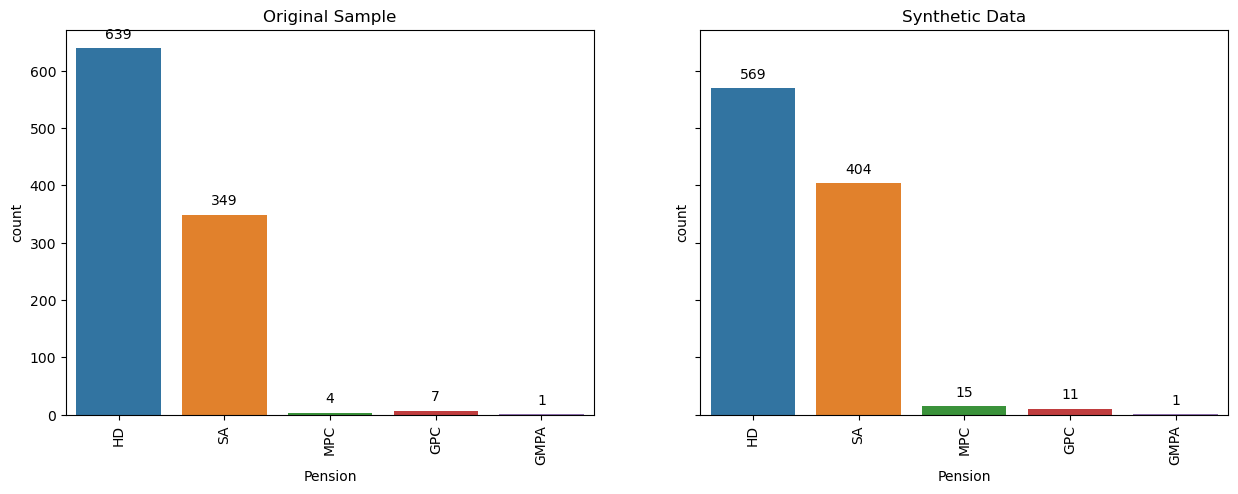

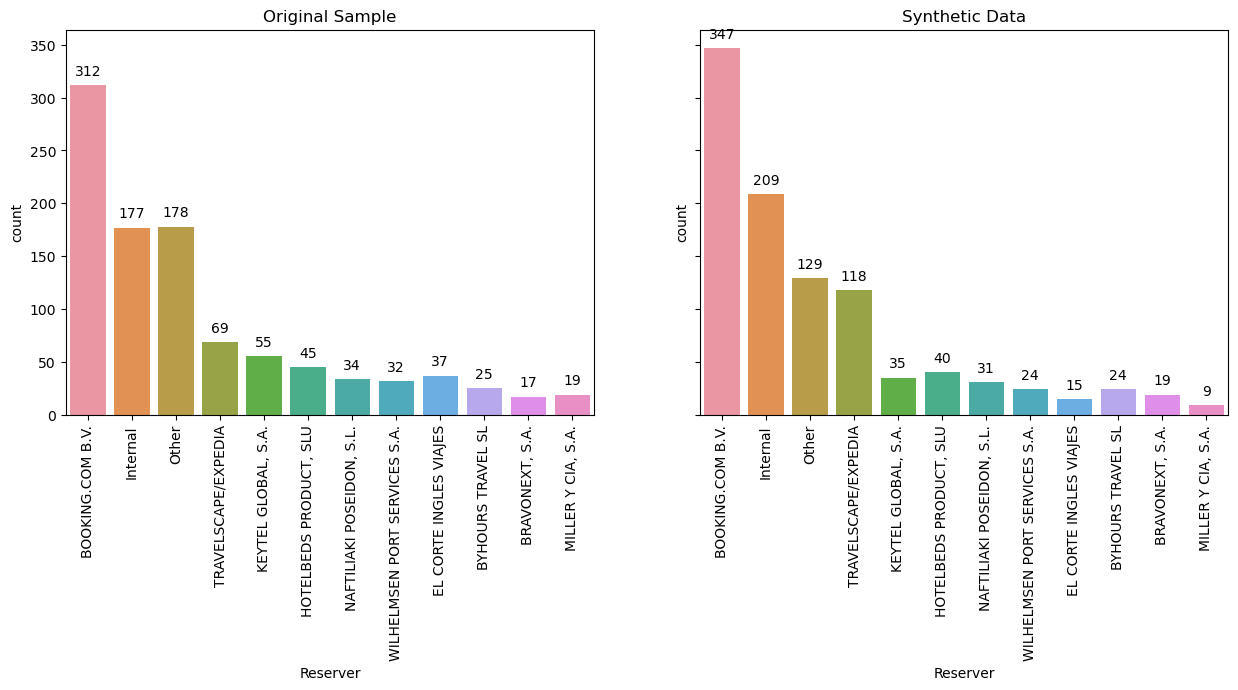

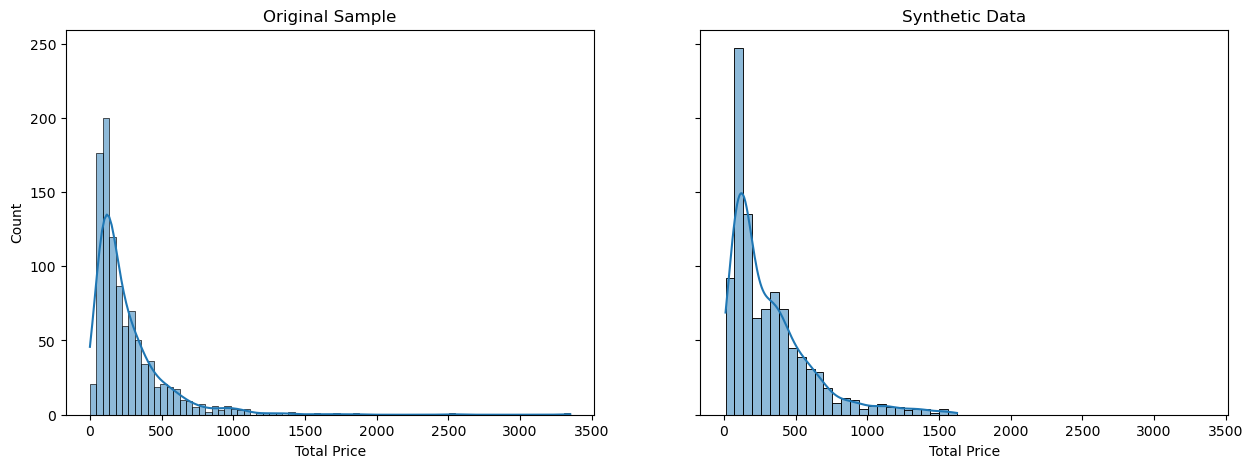

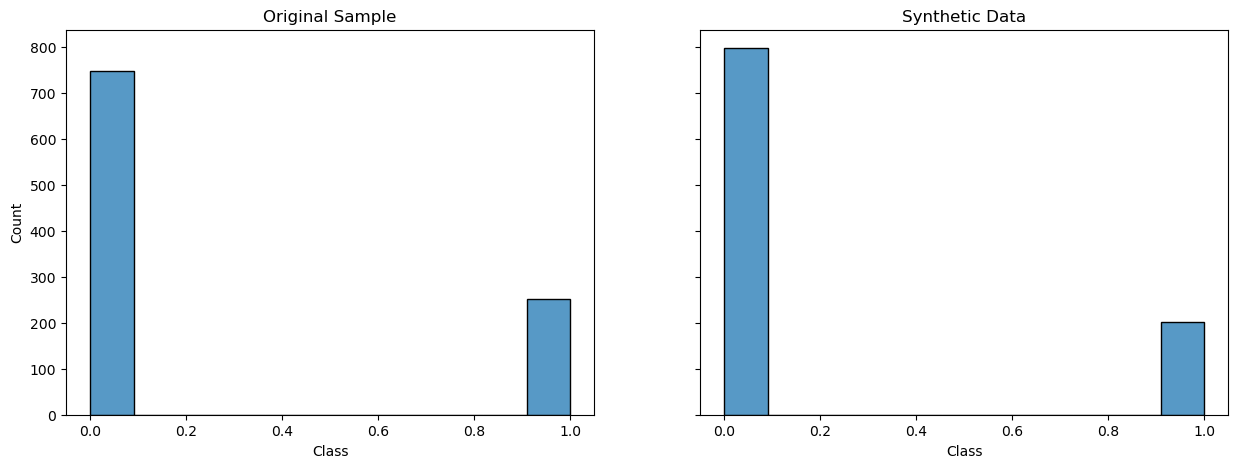

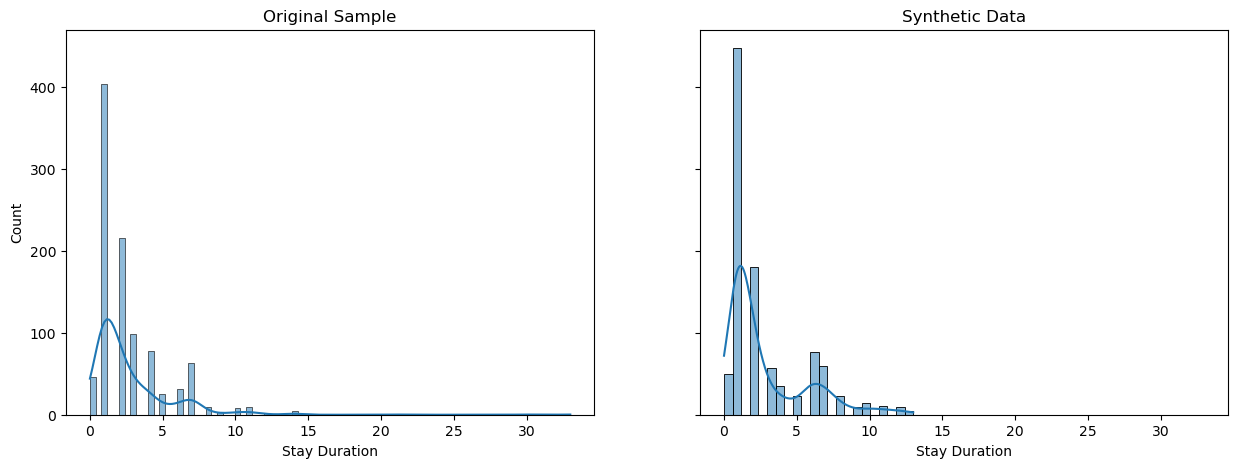

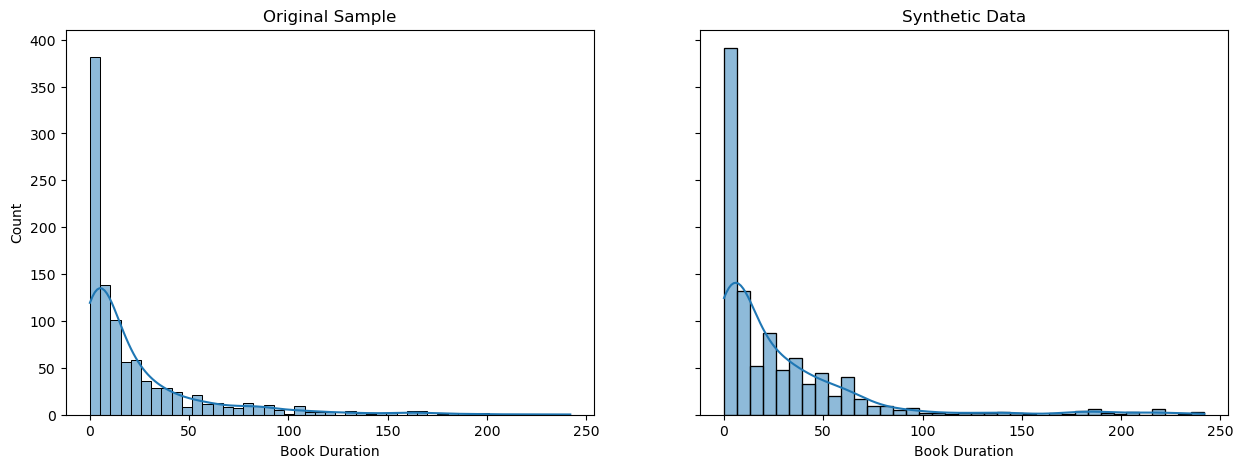

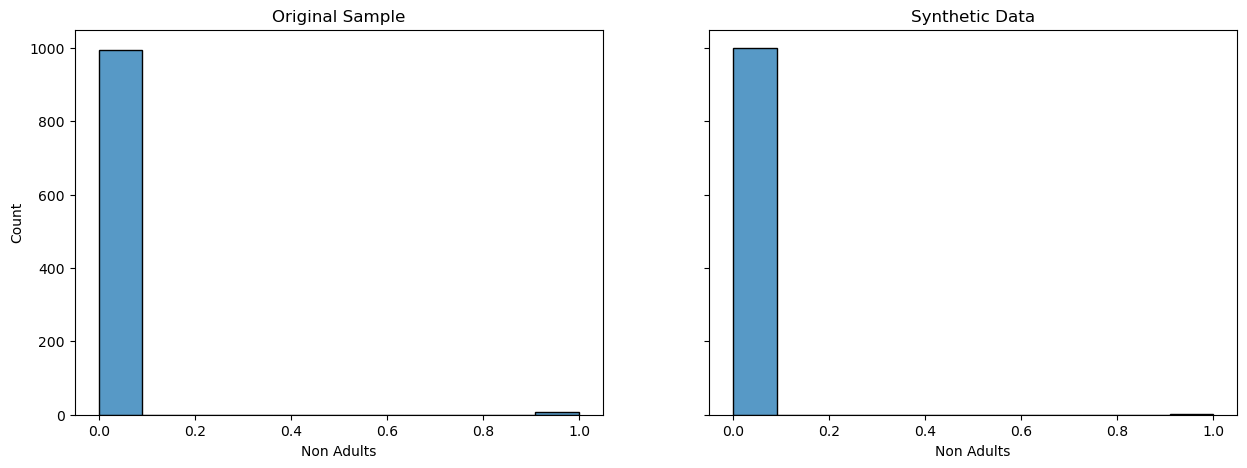

In [ ]:
df_combined = pd.concat([df_sample, df_synthetic_1000])
for col in df_sample.columns:
    if df_sample[col].dtype == 'object':
        unique_vals = sorted(set(df_sample[col].unique()) | set(df_synthetic_1000[col].unique()))
        combined_order = df_combined[col].value_counts().index
        fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)
        sns.countplot(x=col, data=df_sample, order=combined_order, ax=ax[0])
        ax[0].set_title('Original Sample')
        sns.countplot(x=col, data=df_synthetic_1000, order=combined_order, ax=ax[1])
        ax[1].set_title('Synthetic Data')
        ax[0].tick_params(axis='x', labelrotation=90)
        ax[1].tick_params(axis='x', labelrotation=90)
        for p in ax[0].patches:
            ax[0].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
        for p in ax[1].patches:
            ax[1].annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                           ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
        plt.show()
    elif col in ["Adults", "Non Adults", "Class"]:
        fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
        sns.histplot(x=col, data=df_sample, ax=ax[0])
        ax[0].set_title('Original Sample')
        sns.histplot(x=col, data=df_synthetic_1000, ax=ax[1])
        ax[1].set_title('Synthetic Data')
        plt.show()
    else:
        fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True, sharex=True)
        sns.histplot(x=col, data=df_sample, ax=ax[0], kde=True)
        ax[0].set_title('Original Sample')
        sns.histplot(x=col, data=df_synthetic_1000, ax=ax[1], kde=True)
        ax[1].set_title('Synthetic Data')
        plt.show()

In [ ]:
# Calculate KL divergence
categorical_cols = [col for col in df_sample.columns
                    if df_sample[col].dtype == 'object']
categorical_cols.append('Non Adults') # We treat Non Adults as categorical only for the pruposes of this question 
                                      # to avoid getting an inf value of the KL divergences due to the small number 
                                      # of observations with more than 0 non-adults
continuous_cols = [col for col in df_sample.columns
                    if col not in categorical_cols]

# creates an empty dictionary to store the KL divergence for each column.
kl_divergences_Q7B1 = {}

# loop over categorical columns and compute KL divergence for each column
for col in categorical_cols:
    categories = sorted(set(df_sample[col]).union(set(df_synthetic_1000[col])))
    dist1 = df_sample[col].value_counts(normalize=True).reindex(categories, fill_value=1e-9)
    dist2 = df_synthetic_1000[col].value_counts(normalize=True).reindex(categories, fill_value=1e-9)
    kl_div = sum(rel_entr(dist1, dist2))
    kl_divergences_Q7B1[col] = kl_div

# loop over continuous columns and compute KL divergence for each column
for col in continuous_cols:
    # estimates kernel densities for both distributions
    dist1 = gaussian_kde(df_sample[col])
    dist2 = gaussian_kde(df_synthetic_1000[col])

    # evaluates kernel densities on a grid of values
    min_val = min(df_sample[col].min(), df_synthetic_1000[col].min())
    max_val = max(df_sample[col].max(), df_synthetic_1000[col].max())
    values = np.linspace(min_val, max_val, num=1000)
    pdf1 = dist1(values)
    pdf2 = dist2(values)

    # normalizes densities to obtain probability distributions
    dist1 = pdf1 / np.sum(pdf1)
    dist2 = pdf2 / np.sum(pdf2)

    # computes KL divergence using rel_entr and add it to the dictionary
    kl_div = sum(rel_entr(dist1, dist2))
    kl_divergences_Q7B1[col] = kl_div

df_kl_Q7B1 = pd.DataFrame([kl_divergences_Q7B1], index=['KL divergence'])
df_kl_Q7B1

,Country,Pension,Reserver,Non Adults,Adults,Total Price,Class,Stay Duration,Book Duration
KL divergence,0.072052,0.014615,0.046939,0.007639,0.054079,0.272833,0.013772,0.629553,0.045726


Upon plotting the distributions and calculating the KL divergences, it was observed that the majority of variables in both the original and synthetic datasets exhibit marginal distributions that are highly similar. Specifically, the KL divergences of most variables were found to be close to 0. The only exceptions are `Stay Duration` and `Total Price` which have a large KL divergence. It is important to have in mind this divergence, since it will also affect the correlation between variables as shown in question 7C. However, based on these results, it can be concluded that the CTGAN model effectively captured the marginal distribution of most variables.

### 5.2.2. Joint distribution comparison: correlations in the original and synthetic data.

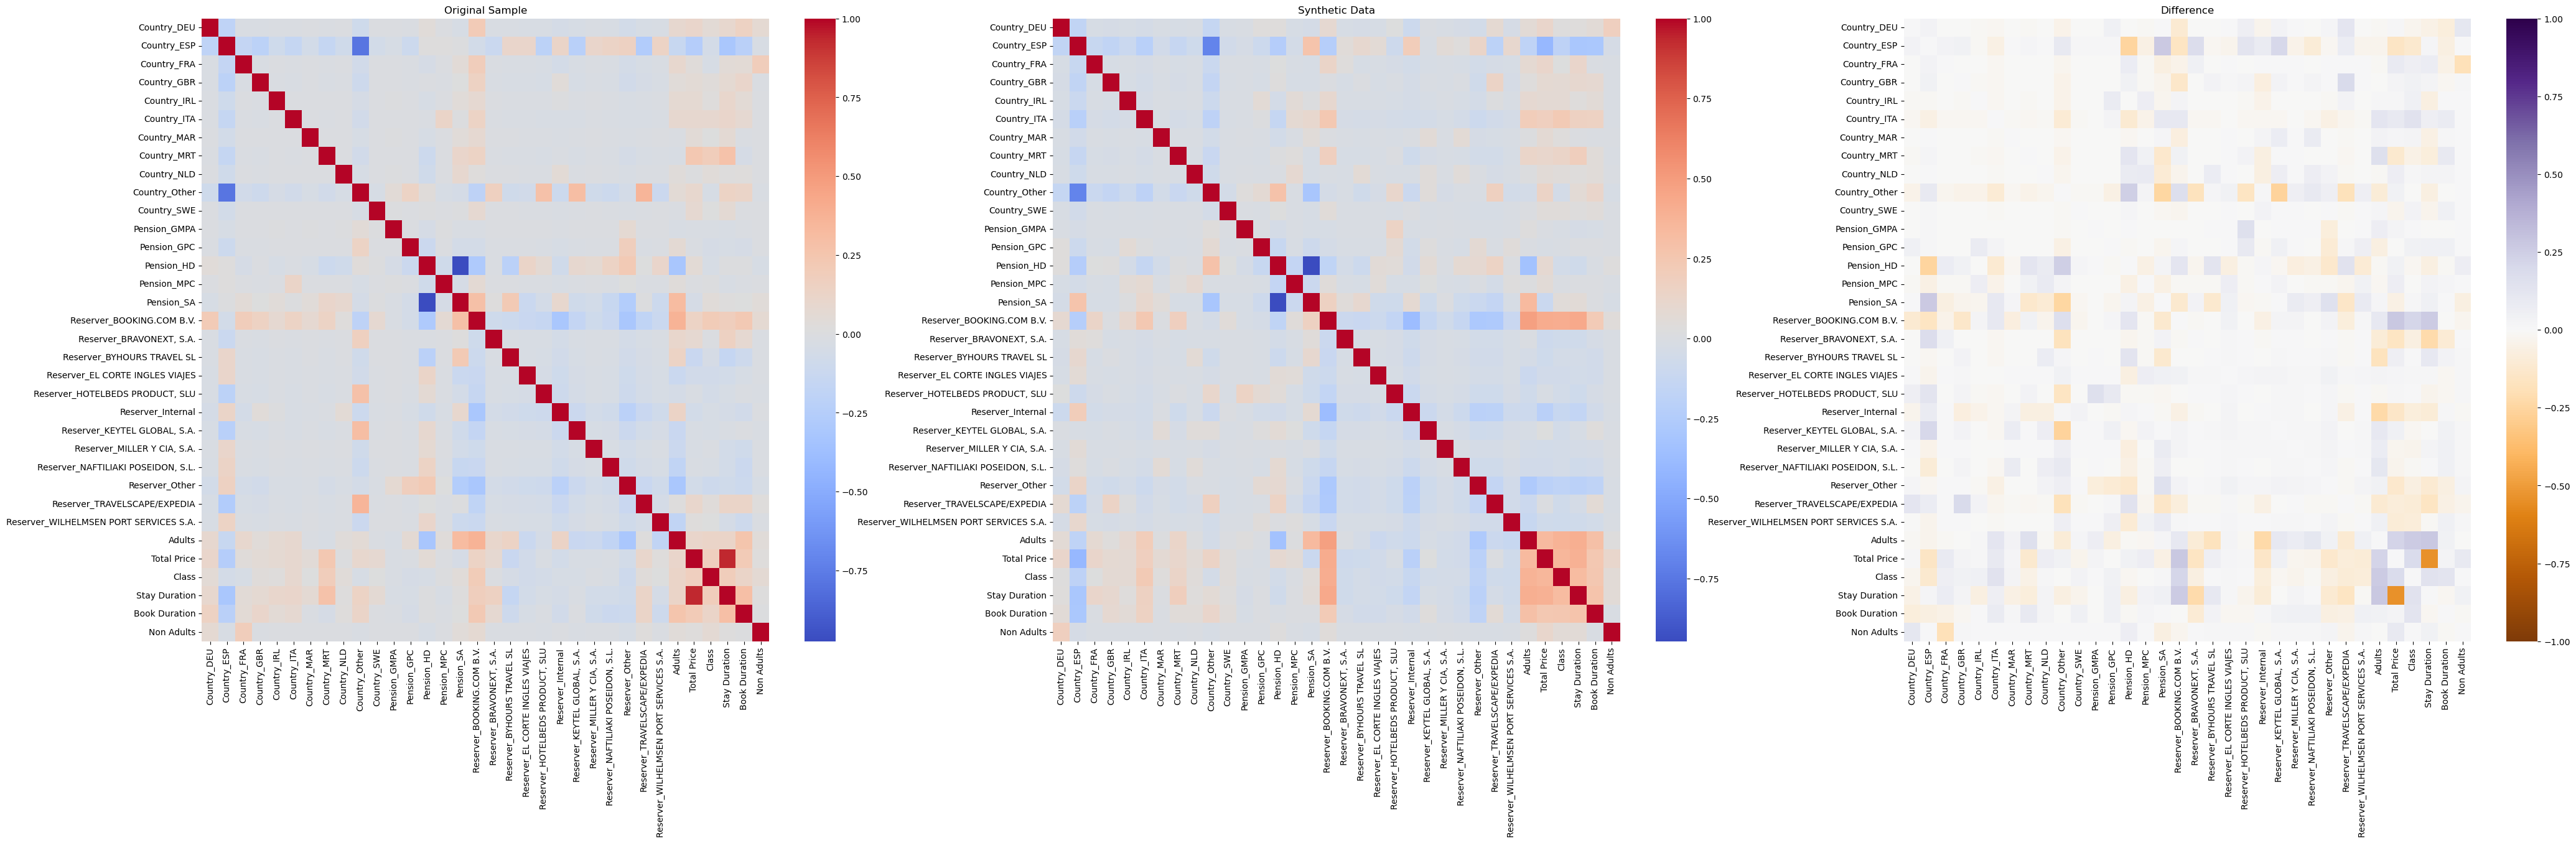

In [ ]:
# Create encoder object
encoder = OneHotEncoder(handle_unknown='ignore')

# Encode categorical columns in both datasets
cat_cols = df_sample.select_dtypes(include=['object']).columns.tolist()
df_sample_encoded = pd.DataFrame(encoder.fit_transform(df_sample[cat_cols]).toarray())
df_synthetic_1000_encoded = pd.DataFrame(encoder.transform(df_synthetic_1000[cat_cols]).toarray())

# Rename columns in the encoded dataframes to match the original column names
df_sample_encoded.columns = encoder.get_feature_names_out(cat_cols)
df_synthetic_1000_encoded.columns = encoder.get_feature_names_out(cat_cols)

df_sample_encoded.index = df_sample.index
df_synthetic_1000_encoded.index = df_synthetic_1000.index

# Concatenate the encoded dataframes with the original numerical dataframes
df_sample_processed = pd.concat([df_sample_encoded, df_sample.select_dtypes(include=['int64', 'float64'])], axis=1)
df_synthetic_1000_processed = pd.concat([df_synthetic_1000_encoded, df_synthetic_1000.select_dtypes(include=['int64', 'float64'])], axis=1)

# Calculate correlations for the original and synthetic data
corr_original = df_sample_processed.corr()
corr_synthetic = df_synthetic_1000_processed.corr()

# Calculate the difference in correlations between the original and synthetic data
corr_diff = corr_synthetic - corr_original

# Plot the heatmaps
fig, axs = plt.subplots(1, 3, figsize=(50,13))
sns.heatmap(corr_original, cmap='coolwarm', ax=axs[0])
sns.heatmap(corr_synthetic, cmap='coolwarm', ax=axs[1])
sns.heatmap(corr_diff, cmap='PuOr', center=0, vmin=-1, vmax=1, ax=axs[2])
axs[0].set_title('Original Sample')
axs[1].set_title('Synthetic Data')
axs[2].set_title('Difference')
plt.show()

In [ ]:
corr_diff["Total Price"]["Stay Duration"]

-0.5452462106806668

As observed from the correlation matrices for the original sample and the synthetic data, the correlations are generally maintained. The third correlation matrix shows the difference in correlations. However, the variables total price and stay duration, lose 0.54 of correlation. In the original data, the correlation between these two variables is significantly strong, being close perfect positive correlation. Intuitevely, the longer the stay duration of a reservation, the higher the expected total price should be. However, after the generation of 1000 rows of synthetic data, some of this correlation is lost.

In [ ]:
df_sample.head()

,Country,Adults,Pension,Reserver,Total Price,Class,Stay Duration,Book Duration,Non Adults
812,ESP,1,SA,BOOKING.COM B.V.,147.90,0,2,45,0
8146,Other,2,HD,BOOKING.COM B.V.,148.41,0,1,0,0
10460,Other,2,HD,TRAVELSCAPE/EXPEDIA,128.52,1,1,134,0
10368,ESP,1,HD,Internal,82.45,1,1,3,0
12632,ESP,1,HD,"NAFTILIAKI POSEIDON, S.L.",284.16,1,2,1,0


In [ ]:
df_synthetic_1000.head()

,Country,Adults,Pension,Reserver,Total Price,Class,Stay Duration,Book Duration,Non Adults
0,Other,2,HD,BOOKING.COM B.V.,1006.89,1,6,80,0
1,Other,2,HD,BOOKING.COM B.V.,1570.99,1,6,126,0
2,Other,1,HD,"HOTELBEDS PRODUCT, SLU",129.04,0,2,38,0
3,Other,1,GPC,BOOKING.COM B.V.,249.06,1,12,9,0
4,ESP,1,HD,"NAFTILIAKI POSEIDON, S.L.",208.71,0,2,24,0


In [ ]:
#creating two copies of the dataframes
df_sample_concat = df_sample.copy()
df_synthetic_1000_concat = df_synthetic_1000.copy()

#creating 3 new columns in both new dataframes
df_sample_concat['CountryClass'] = df_sample_concat['Country'] + df_sample_concat['Class'].astype(str)
df_synthetic_1000_concat['CountryClass'] = df_synthetic_1000_concat['Country'] + df_synthetic_1000_concat['Class'].astype(str)

df_sample_concat['PensionClass'] = df_sample_concat['Pension'] + df_sample_concat['Class'].astype(str)
df_synthetic_1000_concat['PensionClass'] = df_synthetic_1000_concat['Pension'] + df_synthetic_1000_concat['Class'].astype(str)

df_sample_concat['ReserverClass'] = df_sample_concat['Reserver'] + df_sample_concat['Class'].astype(str)
df_synthetic_1000_concat['ReserverClass'] = df_synthetic_1000_concat['Reserver'] + df_synthetic_1000_concat['Class'].astype(str)

In [ ]:
p1 = list(df_sample_concat['CountryClass'].value_counts(normalize=True))
p2 = list(df_sample_concat['PensionClass'].value_counts(normalize=True))
p3 = list(df_sample_concat['ReserverClass'].value_counts(normalize=True))
q1 = list(df_synthetic_1000_concat['CountryClass'].value_counts(normalize=True))
q2 = list(df_synthetic_1000_concat['PensionClass'].value_counts(normalize=True))
q3 = list(df_synthetic_1000_concat['ReserverClass'].value_counts(normalize=True))

In [ ]:
country_comparison = pd.DataFrame(
    {'sample' : round(df_sample_concat['CountryClass'].value_counts(normalize=True), 5),
     'synthetic' : round(df_synthetic_1000_concat['CountryClass'].value_counts(normalize=True), 5), 
    }).fillna(1e-9)

pension_comparison = pd.DataFrame(
    {'sample' : round(df_sample_concat['PensionClass'].value_counts(normalize=True), 5),
     'synthetic' : round(df_synthetic_1000_concat['PensionClass'].value_counts(normalize=True), 5), 
    }).fillna(1e-9)

reserver_comparison = pd.DataFrame(
    {'sample' : round(df_sample_concat['ReserverClass'].value_counts(normalize=True), 5),
     'synthetic' : round(df_synthetic_1000_concat['ReserverClass'].value_counts(normalize=True), 5), 
    }).fillna(1e-9)

display_side_by_side(country_comparison, pension_comparison, reserver_comparison)

,sample,synthetic
DEU0,0.013,0.022
DEU1,0.009,0.008
ESP0,0.476,0.391
ESP1,0.143,0.054
FRA0,0.013,0.013
FRA1,0.002,0.005
GBR0,0.017,0.020
GBR1,0.009,0.012
IRL0,0.003,0.007
IRL1,0.002,0.006


In [ ]:
p_country = list(country_comparison['sample'])
q_country = list(country_comparison['synthetic'])

In [ ]:
p_pension = list(pension_comparison['sample'])
q_pension = list(pension_comparison['synthetic'])

In [ ]:
p_reserver = list(reserver_comparison['sample'])
q_reserver = list(reserver_comparison['synthetic'])

In [ ]:
KL_country = (sum(rel_entr(p_country, q_country))+sum(rel_entr(q_country, p_country)))/ 2
KL_pension = (sum(rel_entr(p_pension, q_pension))+sum(rel_entr(q_pension, p_pension)))/ 2
KL_reserver = (sum(rel_entr(p_reserver, q_reserver))+sum(rel_entr(q_reserver, p_reserver)))/ 2

print("KL divergence for bivariate distribution of Country and Class is:", KL_country)
print("KL divergence for bivariate distribution of Pension and Class is:", KL_pension)
print("KL divergence for bivariate distribution of Reserver and Class is:", KL_reserver)

KL divergence for bivariate distribution of Country and Class is: 0.11269904546767096
KL divergence for bivariate distribution of Pension and Class is: 0.038484516575503974
KL divergence for bivariate distribution of Reserver and Class is: 0.24074300009658883


In order to evaluate how similar the joint distributions are between the original sample and the synthetic data, we concatenate three important categorical variables, specifically country, pension and reserver, with the class. The reason why we select few variables to analyse instead of concatenating all the variables and then calculating the KL divergence is that we would receive many unique categories in the joint distributions, and a proper comparison of the distributions in both samples would not be possible. The KL divergence scores for the three concatenated variables show the distributions are similar, with pension and class being the most similar in both samples. We can observe that as the number of possible classes increases, the KL divergence increases.



# 6. Training and testing the models with original and synthetic data

## 6.1.Training on 500 rows of the original data

We will be using three models for Q8, which are Logistic Regression, Random Forest, and XGBoost models. Each model will be fitted with different combinations of hyperparameters using Grid Search Cross Validation (or GridSearchCV from Scikit-Learn).

In [ ]:
# Prepare functions to refactor the codes and increase readability. 

# Function to scale the dataset
def fit_encoder(df, cat_cols, categories, target_col, has_target):
    """
    Function to fit the One Hot Encoder object to a dataframe.
           df: The DataFrame to be encoded.
           cat_cols: list of categorical columns to be excluded from the encoding operation.
           categories: list of available categories for each categorical columns.
           target_col: target column name.
           has_target: boolean to indicate whether the dataframe contains target column.
    """
    enc = OneHotEncoder(categories=categories, handle_unknown='ignore', drop='first')
    if has_target:
        enc.fit(df.drop(target_col, axis=1)[cat_cols])
    else:
        enc.fit(df[cat_cols])
    return enc

def create_OHE(df, enc, cat_cols, target_col, has_target):
    """
    Function to convert dataframe with categorical columns into one hot encoded columns.
        df: The DataFrame to be processed.
        enc: encoder that will be used on the DataFrame.
        cat_cols: list of categorical columns to be excluded from the one hot encoding operation.
        target_col: target column name.
        has_target: boolean to indicate whether the dataframe contains target column.
    """
    if has_target:
        enc_arr = enc.transform(df.drop(target_col, axis=1)[cat_cols]).toarray()
        df_OHE = pd.DataFrame(enc_arr)
        df_OHE.columns = enc.get_feature_names_out()
        X_OHE = pd.concat([df.reset_index(drop=True).drop(target_col, axis=1), df_OHE], axis=1).drop(cat_cols, axis=1)
        y = df[target_col]
        return X_OHE, y
    else:
        enc_arr = enc.transform(df[cat_cols]).toarray()
        df_OHE = pd.DataFrame(enc_arr)
        df_OHE.columns = enc.get_feature_names_out()
        X_OHE = pd.concat([df.reset_index(drop=True), df_OHE], axis=1).drop(cat_cols, axis=1)
        return X_OHE

In [ ]:
def std_scale_numeric(X, numerical_cols, scaler=None, fit_scaler=False):
    """
    Function to standardise dataframe using `StandardScaler()`. 
        If `fit_scaler` is True, scaler will be fitted to the passed dataframe. 
        Else, will use the scaler that is passed through `scaler`.
    """
    X_original = X.copy()
    if fit_scaler:
        scaler = StandardScaler()
        scaler.fit(X_original[numerical_cols])
    X_scaled = pd.DataFrame(scaler.transform(X_original[numerical_cols]))
    X_scaled.columns = numerical_cols
    X_scaled.index = X_original.index
    for col in X_scaled.columns:
        X_original[col] = X_scaled[col]
    return X_original, scaler

In [ ]:
# Group columns into three different lists
feature_cols = ['Country','Adults','Non Adults','Pension','Reserver','Total Price', 'Stay Duration', 'Book Duration']
target_col = ['Class']
numerical_cols = ['Adults','Non Adults', 'Total Price', 'Stay Duration', 'Book Duration']

# Create list of categories
categories = [list(df_sample['Country'].unique()), list(df_sample['Pension'].unique()), list(df_sample['Reserver'].unique())]


In [ ]:
# Define a dictionary to track training history
history = dict()

In [ ]:
# Split the dataset into training set and test set
seed = 42
X_train, X_test, y_train, y_test = train_test_split(df_sample[feature_cols], df_sample[target_col], test_size=0.5,
                                                    random_state = seed, 
                                                    stratify=None)

In [ ]:
X_train.head()

,Country,Adults,Non Adults,Pension,Reserver,Total Price,Stay Duration,Book Duration
750,Other,1,0,HD,"KEYTEL GLOBAL, S.A.",201.92,3,58
9138,ESP,1,0,HD,"HOTELBEDS PRODUCT, SLU",118.80,1,6
3535,ESP,2,0,SA,BYHOURS TRAVEL SL,34.00,0,5
6828,Other,1,0,SA,"HOTELBEDS PRODUCT, SLU",404.10,5,1
10002,ESP,2,0,SA,Internal,36.80,0,1


In [ ]:
# Scale the training set
X_train_scaled, scaler = std_scale_numeric(X_train, numerical_cols, scaler=None, fit_scaler=True)
print(scaler)
X_train_scaled.head()

StandardScaler()


,Country,Adults,Non Adults,Pension,Reserver,Total Price,Stay Duration,Book Duration
750,Other,-0.904598,-0.063372,HD,"KEYTEL GLOBAL, S.A.",-0.224433,0.061571,1.019779
9138,ESP,-0.904598,-0.063372,HD,"HOTELBEDS PRODUCT, SLU",-0.502463,-0.566702,-0.484235
3535,ESP,1.087908,-0.063372,SA,BYHOURS TRAVEL SL,-0.786112,-0.880839,-0.513158
6828,Other,-0.904598,-0.063372,SA,"HOTELBEDS PRODUCT, SLU",0.451844,0.689844,-0.628851
10002,ESP,1.087908,-0.063372,SA,Internal,-0.776747,-0.880839,-0.628851


In [ ]:
# Fit One Hot Encoder into the training set
cat_cols = ['Country','Pension','Reserver']
target_col = 'Class'
enc = fit_encoder(X_train_scaled, cat_cols, categories, target_col, has_target=False)
X_OHE_train = create_OHE(X_train_scaled, enc, cat_cols, target_col, has_target=False)

In [ ]:
# Scale the test set using the scaler from the training set
X_test_scaled, _ = std_scale_numeric(X_test, numerical_cols, scaler=scaler, fit_scaler=False)
X_OHE_test = create_OHE(X_test_scaled, enc, cat_cols, target_col, has_target=False)

In [ ]:
X_OHE_train.shape

(500, 30)

In [ ]:
X_OHE_train.head()

,Adults,Non Adults,Total Price,Stay Duration,Book Duration,Country_Other,Country_FRA,Country_ITA,Country_NLD,Country_DEU,Country_MRT,Country_GBR,Country_MAR,Country_IRL,Country_SWE,Pension_HD,Pension_GPC,Pension_MPC,Pension_GMPA,Reserver_TRAVELSCAPE/EXPEDIA,Reserver_Internal,"Reserver_NAFTILIAKI POSEIDON, S.L.",Reserver_Other,Reserver_WILHELMSEN PORT SERVICES S.A.,"Reserver_KEYTEL GLOBAL, S.A.","Reserver_HOTELBEDS PRODUCT, SLU",Reserver_EL CORTE INGLES VIAJES,"Reserver_BRAVONEXT, S.A.","Reserver_MILLER Y CIA, S.A.",Reserver_BYHOURS TRAVEL SL
0,-0.904598,-0.063372,-0.224433,0.061571,1.019779,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,-0.904598,-0.063372,-0.502463,-0.566702,-0.484235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,1.087908,-0.063372,-0.786112,-0.880839,-0.513158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.904598,-0.063372,0.451844,0.689844,-0.628851,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,1.087908,-0.063372,-0.776747,-0.880839,-0.628851,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
def fit_estimator(estimator_list, param_list, X_train, y_train):
    """
    Function to fit three models using `GridSearchCV()`
    """
    
    # Assign each estimator to different variables
    estimator_1 = estimator_list[0]
    estimator_2 = estimator_list[1]    
    estimator_3 = estimator_list[2]
    
    # Assign each list of parameters to different variables
    param_1 = param_list[0]
    param_2 = param_list[1]    
    param_3 = param_list[2]
    
    t = time.time()
    print(f'Training estimator {estimator_1}')
    model_1 = GridSearchCV(estimator_1, param_1, scoring='f1', n_jobs=-1)
    model_1.fit(X_train, y_train)
    print(f'Finished training {estimator_1}. Time taken: {round(time.time() - t, 2)}')
    print(f'Best params for {estimator_1}: {model_1.best_params_}')
    
    t = time.time()
    print(f'Training estimator {estimator_2}')
    model_2 = GridSearchCV(estimator_2, param_2, scoring='f1', n_jobs=-1)
    model_2.fit(X_train, y_train)
    print(f'Finished training {estimator_2}. Time taken: {round(time.time() - t, 2)}')
    print(f'Best params for {estimator_2}: {model_2.best_params_}')

    t = time.time()
    print(f'Training estimator {estimator_3}')
    model_3 = GridSearchCV(estimator_3, param_3, scoring='f1', n_jobs=-1)
    model_3.fit(X_train, y_train)
    print(f'Finished training {estimator_3}. Time taken: {round(time.time() - t, 2)}')
    print(f'Best params for {estimator_3}: {model_3.best_params_}')
    
    return model_1, model_2, model_3

In [ ]:
# Define estimators to be used
estimator_list = [LogisticRegression(n_jobs=-1), RandomForestClassifier(n_jobs=-1), XGBClassifier(n_jobs=-1)]

# Define list of hyperparameters to be used
param_list = [{'penalty': [None, 'l1','l2'], 'C': [0.001,0.01,0.1,1,10,100,1000]},
              {'max_depth': [3, 5, 10], 'min_samples_split': [2, 5, 10], 'max_features': [3, 'sqrt', 'log2']},
              {'min_child_weight': [1, 5, 10],'gamma': [0, 1.5, 3],'subsample': [0.6, 0.8, 1.0],'colsample_bytree': [0.6, 0.8, 1.0],'max_depth': [3, 6]}
             ]

# Fit the Logistic Regression, Random Forest, and XGBoost models
model_1, model_2, model_3 = fit_estimator(estimator_list, param_list, X_OHE_train, y_train.values.ravel())

Training estimator LogisticRegression(n_jobs=-1)


/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Finished training LogisticRegression(n_jobs=-1). Time taken: 0.25
Best params for LogisticRegression(n_jobs=-1): {'C': 10, 'penalty': 'l2'}
Training estimator RandomForestClassifier(n_jobs=-1)
Finished training RandomForestClassifier(n_jobs=-1). Time taken: 10.43
Best params for RandomForestClassifier(n_jobs=-1): {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2}
Training estimator XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan

In [ ]:
# Predict the test set using the three models
y_pred_1 = model_1.predict(X_OHE_test)
y_pred_2 = model_2.predict(X_OHE_test)
y_pred_3 = model_3.predict(X_OHE_test)

**Confusion Matrix - Model 1 (Logistic Regression)**

In [ ]:
#Confusion Matrix on the training set (Logistic Regression)
cm_train = confusion_matrix(y_train, model_1.predict(X_OHE_train))
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
display(cm_train)
print(classification_report(y_train, model_1.predict(X_OHE_train)))

array([[372,   4],
       [109,  15]])

              precision    recall  f1-score   support

           0       0.77      0.99      0.87       376
           1       0.79      0.12      0.21       124

    accuracy                           0.77       500
   macro avg       0.78      0.56      0.54       500
weighted avg       0.78      0.77      0.70       500



In [ ]:
#Confusion Matrix on the test set (Logistic Regression)
cm = confusion_matrix(y_test, y_pred_1)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_1).ravel()
print(classification_report(y_test, y_pred_1))
print(precision_score(y_test, y_pred_1, pos_label=1))
print(recall_score(y_test, y_pred_1, pos_label=1))
print(accuracy_score(y_test, y_pred_1))
print(f1_score(y_test, y_pred_1, pos_label=1))

              precision    recall  f1-score   support

           0       0.76      0.96      0.85       372
           1       0.47      0.11      0.18       128

    accuracy                           0.74       500
   macro avg       0.61      0.53      0.51       500
weighted avg       0.68      0.74      0.67       500

0.4666666666666667
0.109375
0.74
0.17721518987341772


In [ ]:
model_name = 'logistic_regression_8A'
history[model_name] = {
    'accuracy' : accuracy_score(y_test, y_pred_1),
    'precision' : precision_score(y_test, y_pred_1, pos_label=1),
    'recall' : recall_score(y_test, y_pred_1, pos_label=1),   
    'f1-score' : f1_score(y_test, y_pred_1, pos_label=1)
}

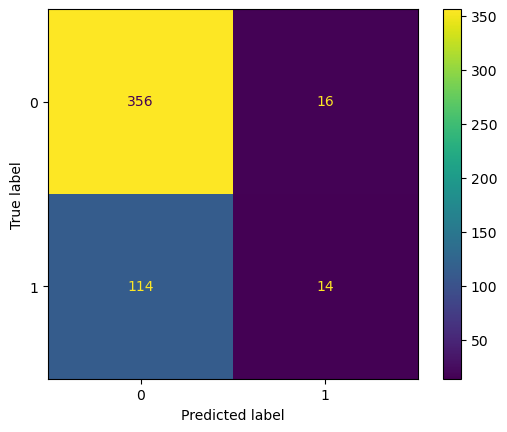

In [ ]:
# Display the confusion matrix from the test set
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_1.classes_)
disp.plot()
plt.show()

**Confusion Matrix - Model 2 (Random Forest)**

In [ ]:
#Confusion Matrix on the training set (Random Forest)
cm_train = confusion_matrix(y_train, model_2.predict(X_OHE_train))
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
display(cm_train)
print(classification_report(y_train, model_2.predict(X_OHE_train)))

array([[376,   0],
       [ 82,  42]])

              precision    recall  f1-score   support

           0       0.82      1.00      0.90       376
           1       1.00      0.34      0.51       124

    accuracy                           0.84       500
   macro avg       0.91      0.67      0.70       500
weighted avg       0.87      0.84      0.80       500



In [ ]:
#Confusion Matrix on the test set (Random Forest)
cm = confusion_matrix(y_test, y_pred_2)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_2).ravel()
print(classification_report(y_test, y_pred_2))
print(precision_score(y_test, y_pred_2, pos_label=1))
print(recall_score(y_test, y_pred_2, pos_label=1))

              precision    recall  f1-score   support

           0       0.76      0.98      0.86       372
           1       0.65      0.10      0.18       128

    accuracy                           0.76       500
   macro avg       0.71      0.54      0.52       500
weighted avg       0.73      0.76      0.68       500

0.65
0.1015625


In [ ]:
model_name = 'random_forest_8A'
history[model_name] = {
    'accuracy' : accuracy_score(y_test, y_pred_2),
    'precision' : precision_score(y_test, y_pred_2, pos_label=1),
    'recall' : recall_score(y_test, y_pred_2, pos_label=1),   
    'f1-score' : f1_score(y_test, y_pred_2, pos_label=1)
}

In [ ]:
pd.DataFrame.from_dict(history).T

,accuracy,precision,recall,f1-score
logistic_regression_8A,0.740,0.466667,0.109375,0.177215
random_forest_8A,0.756,0.650000,0.101562,0.175676


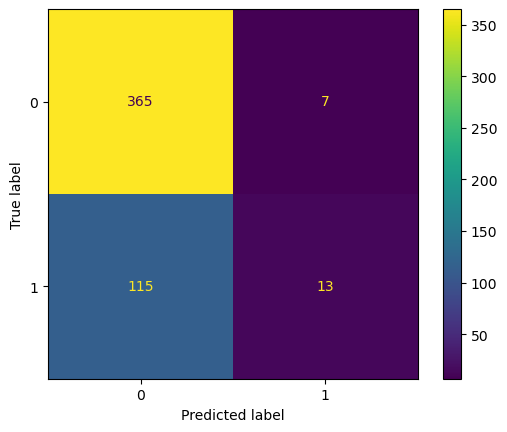

In [ ]:
# Display the confusion matrix from the test set
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_2.classes_)
disp.plot()
plt.show()

**Confusion Matrix - Model 3 (XGBoost)**

In [ ]:
#Confusion Matrix on the training set (XGBoost)
cm_train = confusion_matrix(y_train, model_3.predict(X_OHE_train))
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
display(cm_train)
print(classification_report(y_train, model_3.predict(X_OHE_train)))

array([[374,   2],
       [  8, 116]])

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       376
           1       0.98      0.94      0.96       124

    accuracy                           0.98       500
   macro avg       0.98      0.97      0.97       500
weighted avg       0.98      0.98      0.98       500



In [ ]:
#Confusion Matrix on the test set (XGBoost)
cm = confusion_matrix(y_test, y_pred_3)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_3).ravel()
print(classification_report(y_test, y_pred_3))
print(precision_score(y_test, y_pred_3, pos_label=1))
print(recall_score(y_test, y_pred_3, pos_label=1))

              precision    recall  f1-score   support

           0       0.76      0.87      0.82       372
           1       0.37      0.22      0.28       128

    accuracy                           0.71       500
   macro avg       0.57      0.55      0.55       500
weighted avg       0.66      0.71      0.68       500

0.37333333333333335
0.21875


In [ ]:
model_name = 'xgboost_8A'
history[model_name] = {
    'accuracy' : accuracy_score(y_test, y_pred_3),
    'precision' : precision_score(y_test, y_pred_3, pos_label=1),
    'recall' : recall_score(y_test, y_pred_3, pos_label=1),   
    'f1-score' : f1_score(y_test, y_pred_3, pos_label=1)
}

In [ ]:
pd.DataFrame.from_dict(history).T

,accuracy,precision,recall,f1-score
logistic_regression_8A,0.740,0.466667,0.109375,0.177215
random_forest_8A,0.756,0.650000,0.101562,0.175676
xgboost_8A,0.706,0.373333,0.218750,0.275862


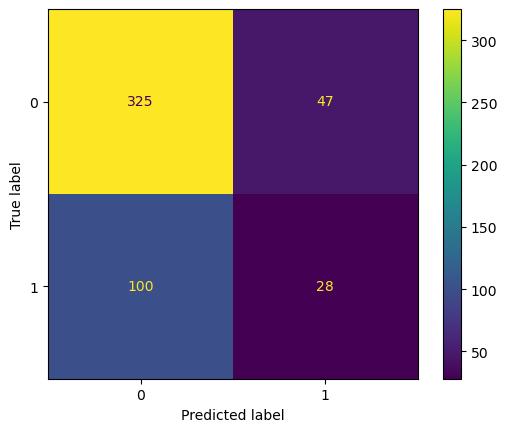

In [ ]:
# Display the confusion matrix from the test set
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_3.classes_)
disp.plot()
plt.show()

## 6.2. Training on 500 rows of the newly generated synthetic data

In [ ]:
# Generate 500 sample data
df_sample_500 = synthetic_model.sample(num_rows=500)
df_sample_500.head()

,Country,Adults,Pension,Reserver,Total Price,Class,Stay Duration,Book Duration,Non Adults
0,Other,2,SA,BOOKING.COM B.V.,535.87,0,3,26,0
1,Other,2,HD,BOOKING.COM B.V.,222.17,0,6,69,0
2,Other,2,SA,BOOKING.COM B.V.,794.15,0,6,32,0
3,ESP,1,HD,"NAFTILIAKI POSEIDON, S.L.",102.35,0,1,2,0
4,ITA,2,SA,BOOKING.COM B.V.,76.78,1,1,178,0


In [ ]:
# Check the distribution of classes on the target variable
df_sample_500['Class'].value_counts()

0    402
1     98
Name: Class, dtype: int64

In [ ]:
# scale and encode the training set
df_sample_500_scaled, scaler = std_scale_numeric(df_sample_500, numerical_cols, scaler=None, fit_scaler=True)
enc = fit_encoder(df_sample_500, cat_cols, categories, target_col='Class', has_target=True)
X_OHE_train_500, y_train_500 = create_OHE(df_sample_500_scaled, enc, cat_cols, target_col='Class', has_target=True)

In [ ]:
# scale and encode the test set using the scaler from training set
X_test_scaled, _ = std_scale_numeric(X_test, numerical_cols, scaler=scaler, fit_scaler=False)
X_OHE_test = create_OHE(X_test_scaled, enc, cat_cols, target_col, has_target=False)

In [ ]:
X_OHE_train_500.shape

(500, 30)

In [ ]:
X_OHE_train_500.head()

,Adults,Total Price,Stay Duration,Book Duration,Non Adults,Country_Other,Country_FRA,Country_ITA,Country_NLD,Country_DEU,Country_MRT,Country_GBR,Country_MAR,Country_IRL,Country_SWE,Pension_HD,Pension_GPC,Pension_MPC,Pension_GMPA,Reserver_TRAVELSCAPE/EXPEDIA,Reserver_Internal,"Reserver_NAFTILIAKI POSEIDON, S.L.",Reserver_Other,Reserver_WILHELMSEN PORT SERVICES S.A.,"Reserver_KEYTEL GLOBAL, S.A.","Reserver_HOTELBEDS PRODUCT, SLU",Reserver_EL CORTE INGLES VIAJES,"Reserver_BRAVONEXT, S.A.","Reserver_MILLER Y CIA, S.A.",Reserver_BYHOURS TRAVEL SL
0,1.045075,0.689814,0.149245,0.002655,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.045075,-0.399859,1.274207,1.122030,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.045075,1.586979,1.274207,0.158847,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.941760,-0.816067,-0.600730,-0.622112,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.045075,-0.904888,-0.600730,3.959514,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# fit the models
model_1, model_2, model_3 = fit_estimator(estimator_list, param_list, X_OHE_train_500, y_train_500.values.ravel())

Training estimator LogisticRegression(n_jobs=-1)


/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logis

Finished training LogisticRegression(n_jobs=-1). Time taken: 0.27
Best params for LogisticRegression(n_jobs=-1): {'C': 100, 'penalty': 'l2'}
Training estimator RandomForestClassifier(n_jobs=-1)
Finished training RandomForestClassifier(n_jobs=-1). Time taken: 10.52
Best params for RandomForestClassifier(n_jobs=-1): {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10}
Training estimator XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=n

In [ ]:
# Re-order the columns 
column_order = pd.Series(X_OHE_train_500.columns)
column_order = list(column_order[~column_order.str.contains(target_col)])

In [ ]:
# predict the test set
y_pred_500_1 = model_1.predict(X_OHE_test[column_order])
y_pred_500_2 = model_2.predict(X_OHE_test[column_order])
y_pred_500_3 = model_3.predict(X_OHE_test[column_order])

**Confusion Matrix - Model 1 (Logistic Regression)**

In [ ]:
# Confusion Matrix - Training Set
cm_train = confusion_matrix(y_train_500, model_1.predict(X_OHE_train_500))
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
display(cm_train)
print(classification_report(y_train_500, model_1.predict(X_OHE_train_500)))

array([[379,  23],
       [ 49,  49]])

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       402
           1       0.68      0.50      0.58        98

    accuracy                           0.86       500
   macro avg       0.78      0.72      0.74       500
weighted avg       0.85      0.86      0.85       500



In [ ]:
# Confusion Matrix - Test Set
cm = confusion_matrix(y_test, y_pred_500_1)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_500_1).ravel()
print(classification_report(y_test, y_pred_500_1))
print(precision_score(y_test, y_pred_500_1, pos_label=1))
print(recall_score(y_test, y_pred_500_1, pos_label=1))

              precision    recall  f1-score   support

           0       0.76      0.95      0.85       372
           1       0.51      0.15      0.23       128

    accuracy                           0.75       500
   macro avg       0.64      0.55      0.54       500
weighted avg       0.70      0.75      0.69       500

0.5135135135135135
0.1484375


In [ ]:
model_name = 'logistic_regression_8B'
history[model_name] = {
    'accuracy' : accuracy_score(y_test, y_pred_500_1),
    'precision' : precision_score(y_test, y_pred_500_1, pos_label=1),
    'recall' : recall_score(y_test, y_pred_500_1, pos_label=1),   
    'f1-score' : f1_score(y_test, y_pred_500_1, pos_label=1)
}

In [ ]:
pd.DataFrame.from_dict(history).T

,accuracy,precision,recall,f1-score
logistic_regression_8A,0.740,0.466667,0.109375,0.177215
random_forest_8A,0.756,0.650000,0.101562,0.175676
xgboost_8A,0.706,0.373333,0.218750,0.275862
logistic_regression_8B,0.746,0.513514,0.148438,0.230303


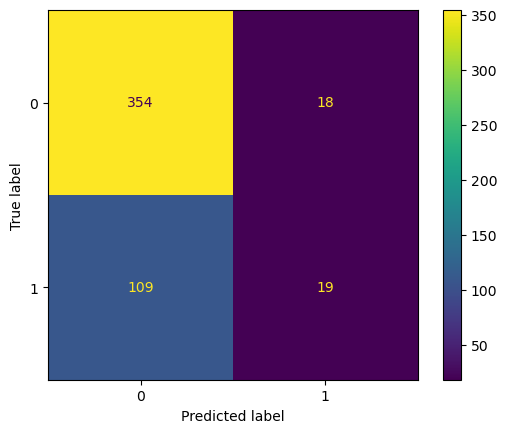

In [ ]:
# Display the Confusion Matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_1.classes_)
disp.plot()
plt.show()

**Confusion Matrix - Model 2 (Random Forest)**

In [ ]:
# Confusion Matrix - Training Set
cm_train = confusion_matrix(y_train_500, model_2.predict(X_OHE_train_500))
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
display(cm_train)
print(classification_report(y_train_500, model_2.predict(X_OHE_train_500)))

array([[398,   4],
       [ 35,  63]])

              precision    recall  f1-score   support

           0       0.92      0.99      0.95       402
           1       0.94      0.64      0.76        98

    accuracy                           0.92       500
   macro avg       0.93      0.82      0.86       500
weighted avg       0.92      0.92      0.92       500



In [ ]:
# Confusion Matrix - Test Set
cm = confusion_matrix(y_test, y_pred_500_2)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_500_2).ravel()
print(classification_report(y_test, y_pred_500_2))
print(precision_score(y_test, y_pred_500_2, pos_label=1))
print(recall_score(y_test, y_pred_500_2, pos_label=1))

              precision    recall  f1-score   support

           0       0.77      0.94      0.85       372
           1       0.50      0.16      0.25       128

    accuracy                           0.74       500
   macro avg       0.63      0.55      0.55       500
weighted avg       0.70      0.74      0.69       500

0.5
0.1640625


In [ ]:
model_name = 'random_forest_8B'
history[model_name] = {
    'accuracy' : accuracy_score(y_test, y_pred_500_2),
    'precision' : precision_score(y_test, y_pred_500_2, pos_label=1),
    'recall' : recall_score(y_test, y_pred_500_2, pos_label=1),   
    'f1-score' : f1_score(y_test, y_pred_500_2, pos_label=1)
}

In [ ]:
pd.DataFrame.from_dict(history).T

,accuracy,precision,recall,f1-score
logistic_regression_8A,0.740,0.466667,0.109375,0.177215
random_forest_8A,0.756,0.650000,0.101562,0.175676
xgboost_8A,0.706,0.373333,0.218750,0.275862
logistic_regression_8B,0.746,0.513514,0.148438,0.230303
random_forest_8B,0.744,0.500000,0.164062,0.247059


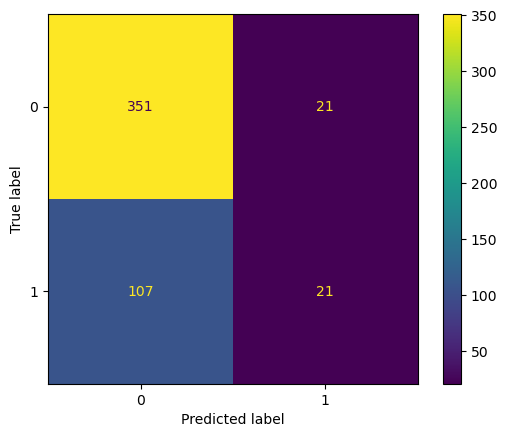

In [ ]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_2.classes_)
disp.plot()
plt.show()

**Confusion Matrix - Model 3 (XGBoost)**

In [ ]:
# Confusion Matrix - Training Set
cm_train = confusion_matrix(y_train_500, model_3.predict(X_OHE_train_500))
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
display(cm_train)
print(classification_report(y_train_500, model_3.predict(X_OHE_train_500)))

array([[399,   3],
       [ 13,  85]])

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       402
           1       0.97      0.87      0.91        98

    accuracy                           0.97       500
   macro avg       0.97      0.93      0.95       500
weighted avg       0.97      0.97      0.97       500



In [ ]:
# Confusion Matrix - Test Set
cm = confusion_matrix(y_test, y_pred_500_3)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_500_3).ravel()
print(classification_report(y_test, y_pred_500_3))
print(precision_score(y_test, y_pred_500_3, pos_label=1))
print(recall_score(y_test, y_pred_500_3, pos_label=1))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       372
           1       0.42      0.20      0.27       128

    accuracy                           0.72       500
   macro avg       0.59      0.55      0.55       500
weighted avg       0.68      0.72      0.69       500

0.41935483870967744
0.203125


In [ ]:
model_name = 'xgboost_8B'
history[model_name] = {
    'accuracy' : accuracy_score(y_test, y_pred_500_3),
    'precision' : precision_score(y_test, y_pred_500_3, pos_label=1),
    'recall' : recall_score(y_test, y_pred_500_3, pos_label=1),   
    'f1-score' : f1_score(y_test, y_pred_500_3, pos_label=1)
}

In [ ]:
pd.DataFrame.from_dict(history).T

,accuracy,precision,recall,f1-score
logistic_regression_8A,0.740,0.466667,0.109375,0.177215
random_forest_8A,0.756,0.650000,0.101562,0.175676
xgboost_8A,0.706,0.373333,0.218750,0.275862
logistic_regression_8B,0.746,0.513514,0.148438,0.230303
random_forest_8B,0.744,0.500000,0.164062,0.247059
xgboost_8B,0.724,0.419355,0.203125,0.273684


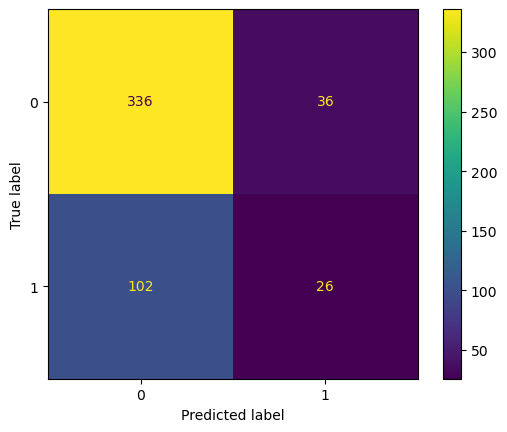

In [ ]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_3.classes_)
disp.plot()
plt.show()

## 6.3. Training on the 10,000 rows of new synthetic data

In [ ]:
# Sample 10000 synthetic data
df_sample_10000 = synthetic_model.sample(num_rows=10000)
df_sample_10000.tail()

,Country,Adults,Pension,Reserver,Total Price,Class,Stay Duration,Book Duration,Non Adults
9995,ITA,2,SA,BOOKING.COM B.V.,62.72,1,1,32,0
9996,ESP,1,HD,Other,418.56,0,1,4,0
9997,Other,1,HD,TRAVELSCAPE/EXPEDIA,589.44,0,2,32,0
9998,Other,1,HD,TRAVELSCAPE/EXPEDIA,129.45,0,2,10,0
9999,ESP,2,SA,BOOKING.COM B.V.,376.15,1,1,20,0


In [ ]:
# Check the distribution on the target variable
df_sample_10000['Class'].value_counts()

0    7951
1    2049
Name: Class, dtype: int64

In [ ]:
# scale and encode the training set
df_sample_10000_scaled, scaler = std_scale_numeric(df_sample_10000, numerical_cols, scaler=None, fit_scaler=True)
enc = fit_encoder(df_sample_10000, cat_cols, categories, target_col='Class', has_target=True)
X_OHE_train_10000, y_train_10000 = create_OHE(df_sample_10000_scaled, enc, cat_cols, target_col='Class', has_target=True)

In [ ]:
# scale and encode the test set
X_test_scaled, _ = std_scale_numeric(X_test, numerical_cols, scaler=scaler, fit_scaler=False)
X_OHE_test = create_OHE(X_test_scaled, enc, cat_cols, target_col, has_target=False)

In [ ]:
X_OHE_train_10000.shape

(10000, 30)

In [ ]:
X_OHE_train_10000.head()

,Adults,Total Price,Stay Duration,Book Duration,Non Adults,Country_Other,Country_FRA,Country_ITA,Country_NLD,Country_DEU,Country_MRT,Country_GBR,Country_MAR,Country_IRL,Country_SWE,Pension_HD,Pension_GPC,Pension_MPC,Pension_GMPA,Reserver_TRAVELSCAPE/EXPEDIA,Reserver_Internal,"Reserver_NAFTILIAKI POSEIDON, S.L.",Reserver_Other,Reserver_WILHELMSEN PORT SERVICES S.A.,"Reserver_KEYTEL GLOBAL, S.A.","Reserver_HOTELBEDS PRODUCT, SLU",Reserver_EL CORTE INGLES VIAJES,"Reserver_BRAVONEXT, S.A.","Reserver_MILLER Y CIA, S.A.",Reserver_BYHOURS TRAVEL SL
0,-0.911151,-0.835287,-0.652924,-0.450338,-0.054855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.087864,-0.220445,1.194208,-0.344870,-0.054855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.087864,0.474073,-0.652924,-0.503072,-0.054855,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1.087864,-0.321255,1.563635,0.076999,-0.054855,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.911151,-1.056302,-0.652924,-0.687639,-0.054855,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Train the models
model_1, model_2, model_3 = fit_estimator(estimator_list, param_list, X_OHE_train_10000, y_train_10000.values.ravel())

Training estimator LogisticRegression(n_jobs=-1)


/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 105.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line

Finished training LogisticRegression(n_jobs=-1). Time taken: 1.41
Best params for LogisticRegression(n_jobs=-1): {'C': 1000, 'penalty': 'l2'}
Training estimator RandomForestClassifier(n_jobs=-1)
Finished training RandomForestClassifier(n_jobs=-1). Time taken: 20.91
Best params for RandomForestClassifier(n_jobs=-1): {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 10}
Training estimator XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=

In [ ]:
# Re-order the columns
column_order = pd.Series(X_OHE_train_10000.columns)
column_order = list(column_order[~column_order.str.contains(target_col)])

In [ ]:
# Predict the test set
y_pred_10000_1 = model_1.predict(X_OHE_test[column_order])
y_pred_10000_2 = model_2.predict(X_OHE_test[column_order])
y_pred_10000_3 = model_3.predict(X_OHE_test[column_order])

**Confusion Matrix - Model 1 (Logistic Regression)**

In [ ]:
# Confusion Matrix - Training Set
cm_train = confusion_matrix(y_train_10000, model_1.predict(X_OHE_train_10000))
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
display(cm_train)
print(classification_report(y_train_10000, model_1.predict(X_OHE_train_10000)))

array([[7409,  542],
       [1047, 1002]])

              precision    recall  f1-score   support

           0       0.88      0.93      0.90      7951
           1       0.65      0.49      0.56      2049

    accuracy                           0.84     10000
   macro avg       0.76      0.71      0.73     10000
weighted avg       0.83      0.84      0.83     10000



In [ ]:
# Confusion Matrix - Test Set
cm = confusion_matrix(y_test, y_pred_10000_1)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_10000_1).ravel()
print(classification_report(y_test, y_pred_10000_1))
print(precision_score(y_test, y_pred_10000_1, pos_label=1))
print(recall_score(y_test, y_pred_10000_1, pos_label=1))

              precision    recall  f1-score   support

           0       0.77      0.96      0.85       372
           1       0.58      0.15      0.24       128

    accuracy                           0.75       500
   macro avg       0.67      0.56      0.54       500
weighted avg       0.72      0.75      0.70       500

0.5757575757575758
0.1484375


In [ ]:
model_name = 'logistic_regression_8C'
history[model_name] = {
    'accuracy' : accuracy_score(y_test, y_pred_10000_1),
    'precision' : precision_score(y_test, y_pred_10000_1, pos_label=1),
    'recall' : recall_score(y_test, y_pred_10000_1, pos_label=1),   
    'f1-score' : f1_score(y_test, y_pred_10000_1, pos_label=1)
}

In [ ]:
pd.DataFrame.from_dict(history).T

,accuracy,precision,recall,f1-score
logistic_regression_8A,0.740,0.466667,0.109375,0.177215
random_forest_8A,0.756,0.650000,0.101562,0.175676
xgboost_8A,0.706,0.373333,0.218750,0.275862
logistic_regression_8B,0.746,0.513514,0.148438,0.230303
random_forest_8B,0.744,0.500000,0.164062,0.247059
xgboost_8B,0.724,0.419355,0.203125,0.273684
logistic_regression_8C,0.754,0.575758,0.148438,0.236025


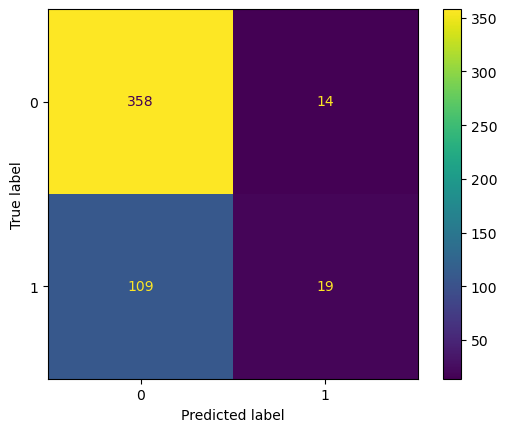

In [ ]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_1.classes_)
disp.plot()
plt.show()

**Confusion Matrix - Model 2 (Random Forest)**

In [ ]:
# Confusion Matrix - Training Set
cm_train = confusion_matrix(y_train_10000, model_2.predict(X_OHE_train_10000))
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
display(cm_train)
print(classification_report(y_train_10000, model_2.predict(X_OHE_train_10000)))

array([[7538,  413],
       [ 996, 1053]])

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      7951
           1       0.72      0.51      0.60      2049

    accuracy                           0.86     10000
   macro avg       0.80      0.73      0.76     10000
weighted avg       0.85      0.86      0.85     10000



In [ ]:
# Confusion Matrix - Test Set
cm = confusion_matrix(y_test, y_pred_10000_2)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_10000_2).ravel()
print(classification_report(y_test, y_pred_10000_2))
print(precision_score(y_test, y_pred_10000_2, pos_label=1))
print(recall_score(y_test, y_pred_10000_2, pos_label=1))

              precision    recall  f1-score   support

           0       0.77      0.95      0.85       372
           1       0.56      0.17      0.26       128

    accuracy                           0.75       500
   macro avg       0.67      0.56      0.56       500
weighted avg       0.72      0.75      0.70       500

0.5641025641025641
0.171875


In [ ]:
model_name = 'random_forest_8C'
history[model_name] = {
    'accuracy' : accuracy_score(y_test, y_pred_10000_2),
    'precision' : precision_score(y_test, y_pred_10000_2, pos_label=1),
    'recall' : recall_score(y_test, y_pred_10000_2, pos_label=1),   
    'f1-score' : f1_score(y_test, y_pred_10000_2, pos_label=1)
}

In [ ]:
pd.DataFrame.from_dict(history).T

,accuracy,precision,recall,f1-score
logistic_regression_8A,0.740,0.466667,0.109375,0.177215
random_forest_8A,0.756,0.650000,0.101562,0.175676
xgboost_8A,0.706,0.373333,0.218750,0.275862
logistic_regression_8B,0.746,0.513514,0.148438,0.230303
random_forest_8B,0.744,0.500000,0.164062,0.247059
xgboost_8B,0.724,0.419355,0.203125,0.273684
logistic_regression_8C,0.754,0.575758,0.148438,0.236025
random_forest_8C,0.754,0.564103,0.171875,0.263473


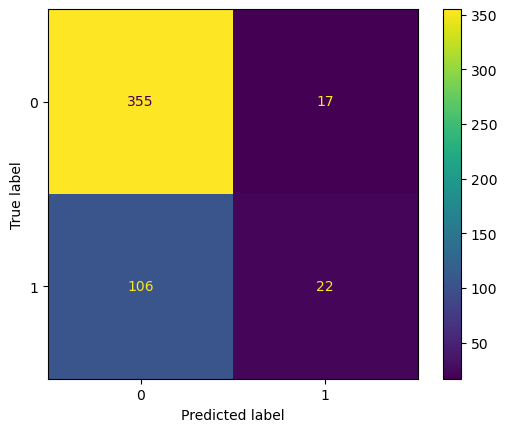

In [ ]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_2.classes_)
disp.plot()
plt.show()

**Confusion Matrix - Model 3 (XGBoost)**

In [ ]:
# Confusion Matrix - Training Set
cm_train = confusion_matrix(y_train_10000, model_3.predict(X_OHE_train_10000))
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
display(cm_train)
print(classification_report(y_train_10000, model_3.predict(X_OHE_train_10000)))

array([[7429,  522],
       [ 913, 1136]])

              precision    recall  f1-score   support

           0       0.89      0.93      0.91      7951
           1       0.69      0.55      0.61      2049

    accuracy                           0.86     10000
   macro avg       0.79      0.74      0.76     10000
weighted avg       0.85      0.86      0.85     10000



In [ ]:
# Confusion Matrix - Test Set
cm = confusion_matrix(y_test, y_pred_10000_3)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_10000_3).ravel()
print(classification_report(y_test, y_pred_10000_3))
print(precision_score(y_test, y_pred_10000_3, pos_label=1))
print(recall_score(y_test, y_pred_10000_3, pos_label=1))

              precision    recall  f1-score   support

           0       0.78      0.95      0.86       372
           1       0.62      0.22      0.32       128

    accuracy                           0.77       500
   macro avg       0.70      0.59      0.59       500
weighted avg       0.74      0.77      0.72       500

0.6222222222222222
0.21875


In [ ]:
model_name = 'xgboost_8C'
history[model_name] = {
    'accuracy' : accuracy_score(y_test, y_pred_10000_3),
    'precision' : precision_score(y_test, y_pred_10000_3, pos_label=1),
    'recall' : recall_score(y_test, y_pred_10000_3, pos_label=1),   
    'f1-score' : f1_score(y_test, y_pred_10000_3, pos_label=1)
}

In [ ]:
pd.DataFrame.from_dict(history).T

,accuracy,precision,recall,f1-score
logistic_regression_8A,0.740,0.466667,0.109375,0.177215
random_forest_8A,0.756,0.650000,0.101562,0.175676
xgboost_8A,0.706,0.373333,0.218750,0.275862
logistic_regression_8B,0.746,0.513514,0.148438,0.230303
random_forest_8B,0.744,0.500000,0.164062,0.247059
xgboost_8B,0.724,0.419355,0.203125,0.273684
logistic_regression_8C,0.754,0.575758,0.148438,0.236025
random_forest_8C,0.754,0.564103,0.171875,0.263473
xgboost_8C,0.766,0.622222,0.218750,0.323699


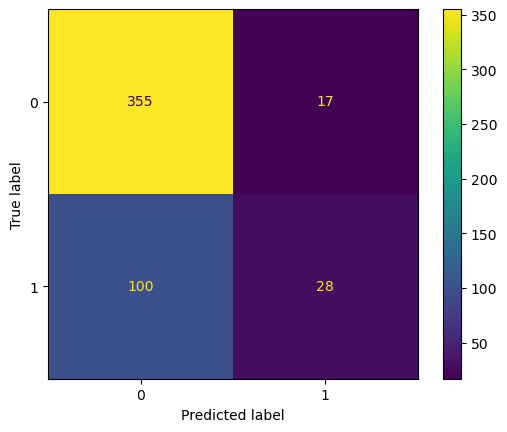

In [ ]:
# Display the confusion matri
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_3.classes_)
disp.plot()
plt.show()

## 6.4. Training on the 10,000 rows of balanced synthetic data

In [ ]:
df_sample_10000

,Country,Adults,Pension,Reserver,Total Price,Class,Stay Duration,Book Duration,Non Adults
0,ESP,1,HD,"MILLER Y CIA, S.A.",87.40,0,1,10,0
1,ESP,2,SA,Internal,260.49,1,6,14,0
2,ITA,2,HD,"HOTELBEDS PRODUCT, SLU",456.01,0,1,8,0
3,Other,2,GPC,Other,232.11,1,7,30,0
4,ESP,1,HD,Other,25.18,0,1,1,0
...,...,...,...,...,...,...,...,...,...
9995,ITA,2,SA,BOOKING.COM B.V.,62.72,1,1,32,0
9996,ESP,1,HD,Other,418.56,0,1,4,0
9997,Other,1,HD,TRAVELSCAPE/EXPEDIA,589.44,0,2,32,0
9998,Other,1,HD,TRAVELSCAPE/EXPEDIA,129.45,0,2,10,0


In [ ]:
print(df_sample_10000['Class'].value_counts())

# Select 5000 rows randomly from the 'Class' 0
df_class_0 = df_sample_10000.query('Class == 0').sample(n=5000, random_state=42)

# Select all rows from 'Class' 1
df_class_1 = df_sample_10000.query('Class == 1')

# Concatenate the two dataframes
df_sample_10000 = pd.concat([df_class_0, df_class_1], ignore_index=True)

df_sample_10000['Class'].value_counts()

0    7951
1    2049
Name: Class, dtype: int64


0    5000
1    2049
Name: Class, dtype: int64

In [ ]:
# Calculate the number of minority class to be generated
num_of_remaining_minority = df_sample_10000['Class'].value_counts()[0] - df_sample_10000['Class'].value_counts()[1]
print(num_of_remaining_minority)
condition = Condition({'Class': 1}, num_rows=num_of_remaining_minority)

2951


In [ ]:
# Perform rejection sampling to generate the minority class observations
df_rejection_sampling = synthetic_model.sample_conditions(conditions=[condition])
print(df_rejection_sampling.shape)
df_rejection_sampling.head()

Sampling conditions:   0%|          | 0/2951 [00:00<?, ?it/s]/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sdv/tabular/base.py:599: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for group, dataframe in grouped_conditions:
/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sdv/tabular/base.py:632: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for transformed_group, transformed_dataframe in transformed_groups:
Sampling conditions: 100%|██████████| 2951/2951 [00:00<00:00, 3125.97it/s]

(2951, 9)


,Country,Adults,Pension,Reserver,Total Price,Class,Stay Duration,Book Duration,Non Adults
0,Other,2,HD,BOOKING.COM B.V.,378.87,1,8,77,0
1,ESP,2,SA,BOOKING.COM B.V.,258.46,1,3,34,0
2,Other,2,SA,BOOKING.COM B.V.,308.46,1,2,23,0
3,Other,2,HD,BOOKING.COM B.V.,603.11,1,7,43,0
4,Other,1,HD,Internal,286.38,1,5,8,0


In [ ]:
# Concatenate the balanced dataset
X_train_balanced = pd.concat([df_sample_10000.drop('Class', axis=1), df_rejection_sampling.drop('Class', axis=1)])
y_train_balanced = pd.concat([pd.Series(df_sample_10000['Class'].values.ravel()), df_rejection_sampling['Class']])
y_train_balanced.value_counts()

0    5000
1    5000
dtype: int64

In [ ]:
# Scale and encode the training set
cat_cols = ['Country','Pension','Reserver']
target_col = 'Class'
X_train_balanced_scaled, scaler = std_scale_numeric(X_train_balanced, numerical_cols, scaler=None, fit_scaler=True)
enc = fit_encoder(X_train_balanced_scaled, cat_cols, categories, target_col, has_target=False)
X_OHE_train_balanced = create_OHE(X_train_balanced_scaled, enc, cat_cols, target_col, has_target=False)

In [ ]:
X_OHE_train_balanced.shape

(10000, 30)

In [ ]:
X_OHE_train_balanced.head()

,Adults,Total Price,Stay Duration,Book Duration,Non Adults,Country_Other,Country_FRA,Country_ITA,Country_NLD,Country_DEU,Country_MRT,Country_GBR,Country_MAR,Country_IRL,Country_SWE,Pension_HD,Pension_GPC,Pension_MPC,Pension_GMPA,Reserver_TRAVELSCAPE/EXPEDIA,Reserver_Internal,"Reserver_NAFTILIAKI POSEIDON, S.L.",Reserver_Other,Reserver_WILHELMSEN PORT SERVICES S.A.,"Reserver_KEYTEL GLOBAL, S.A.","Reserver_HOTELBEDS PRODUCT, SLU",Reserver_EL CORTE INGLES VIAJES,"Reserver_BRAVONEXT, S.A.","Reserver_MILLER Y CIA, S.A.",Reserver_BYHOURS TRAVEL SL
0,0.807024,-0.286997,0.829610,3.867397,-0.060108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.807024,-0.334420,0.829610,0.796964,-0.060108,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.807024,0.727811,-1.158433,-0.218641,-0.060108,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-1.227833,-1.085113,-0.495752,0.017546,-0.060108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.807024,-0.478838,2.154972,2.166849,-0.060108,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
# Scale and encode the test set
X_test_scaled, _ = std_scale_numeric(X_test, numerical_cols, scaler=scaler, fit_scaler=False)
X_OHE_test = create_OHE(X_test_scaled, enc, cat_cols, target_col, has_target=False)

In [ ]:
# Train the models
model_1, model_2, model_3 = fit_estimator(estimator_list, param_list, X_OHE_train_balanced, y_train_balanced)

Training estimator LogisticRegression(n_jobs=-1)


/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
70 fits failed out of a total of 105.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
35 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/anaconda/envs/Python3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line

Finished training LogisticRegression(n_jobs=-1). Time taken: 1.35
Best params for LogisticRegression(n_jobs=-1): {'C': 1, 'penalty': 'l2'}
Training estimator RandomForestClassifier(n_jobs=-1)
Finished training RandomForestClassifier(n_jobs=-1). Time taken: 20.65
Best params for RandomForestClassifier(n_jobs=-1): {'max_depth': 10, 'max_features': 3, 'min_samples_split': 2}
Training estimator XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, mono

In [ ]:
# Re-order the columns
column_order = pd.Series(X_OHE_train_balanced.columns)
column_order = list(column_order[~column_order.str.contains(target_col)])

In [ ]:
# Predict the test set
y_pred_balanced_1 = model_1.predict(X_OHE_test[column_order])
y_pred_balanced_2 = model_2.predict(X_OHE_test[column_order])
y_pred_balanced_3 = model_3.predict(X_OHE_test[column_order])

**Confusion Matrix - Model 1 (Logistic Regression)**

In [ ]:
# Confusion matrix - train set
cm_train = confusion_matrix(y_train_balanced, model_1.predict(X_OHE_train_balanced))
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
display(cm_train)
print(classification_report(y_train_balanced, model_1.predict(X_OHE_train_balanced)))

array([[3890, 1110],
       [1011, 3989]])

              precision    recall  f1-score   support

           0       0.79      0.78      0.79      5000
           1       0.78      0.80      0.79      5000

    accuracy                           0.79     10000
   macro avg       0.79      0.79      0.79     10000
weighted avg       0.79      0.79      0.79     10000



In [ ]:
# Confusion matrix - test set
cm = confusion_matrix(y_test, y_pred_balanced_1)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_balanced_1).ravel()
print(classification_report(y_test, y_pred_balanced_1))
print(precision_score(y_test, y_pred_balanced_1, pos_label=1))
print(recall_score(y_test, y_pred_balanced_1, pos_label=1))

              precision    recall  f1-score   support

           0       0.82      0.78      0.80       372
           1       0.44      0.50      0.47       128

    accuracy                           0.71       500
   macro avg       0.63      0.64      0.63       500
weighted avg       0.72      0.71      0.71       500

0.43537414965986393
0.5


In [ ]:
model_name = 'logistic_regression_8D_synthetic'
history[model_name] = {
    'accuracy' : accuracy_score(y_test, y_pred_balanced_1),
    'precision' : precision_score(y_test, y_pred_balanced_1, pos_label=1),
    'recall' : recall_score(y_test, y_pred_balanced_1, pos_label=1),   
    'f1-score' : f1_score(y_test, y_pred_balanced_1, pos_label=1)
}

In [ ]:
pd.DataFrame.from_dict(history).T

,accuracy,precision,recall,f1-score
logistic_regression_8A,0.740,0.466667,0.109375,0.177215
random_forest_8A,0.756,0.650000,0.101562,0.175676
xgboost_8A,0.706,0.373333,0.218750,0.275862
logistic_regression_8B,0.746,0.513514,0.148438,0.230303
random_forest_8B,0.744,0.500000,0.164062,0.247059
xgboost_8B,0.724,0.419355,0.203125,0.273684
logistic_regression_8C,0.754,0.575758,0.148438,0.236025
random_forest_8C,0.754,0.564103,0.171875,0.263473
xgboost_8C,0.766,0.622222,0.218750,0.323699
logistic_regression_8D_synthetic,0.706,0.435374,0.500000,0.465455


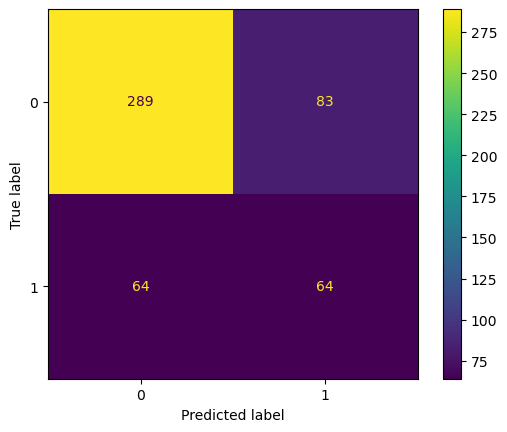

In [ ]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_1.classes_)
disp.plot()
plt.show()

**Confusion Matrix - Model 2 (Random Forest)**

In [ ]:
# Confusion matrix - training set
cm_train = confusion_matrix(y_train_balanced, model_2.predict(X_OHE_train_balanced))
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
display(cm_train)
print(classification_report(y_train_balanced, model_2.predict(X_OHE_train_balanced)))

array([[3967, 1033],
       [ 809, 4191]])

              precision    recall  f1-score   support

           0       0.83      0.79      0.81      5000
           1       0.80      0.84      0.82      5000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



In [ ]:
# Confusion matrix - test set
cm = confusion_matrix(y_test, y_pred_balanced_2)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_balanced_2).ravel()
print(classification_report(y_test, y_pred_balanced_2))
print(precision_score(y_test, y_pred_balanced_2, pos_label=1))
print(recall_score(y_test, y_pred_balanced_2, pos_label=1))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       372
           1       0.45      0.55      0.49       128

    accuracy                           0.71       500
   macro avg       0.64      0.66      0.65       500
weighted avg       0.73      0.71      0.72       500

0.45161290322580644
0.546875


In [ ]:
model_name = 'random_forest_8D_synthetic'
history[model_name] = {
    'accuracy' : accuracy_score(y_test, y_pred_balanced_2),
    'precision' : precision_score(y_test, y_pred_balanced_2, pos_label=1),
    'recall' : recall_score(y_test, y_pred_balanced_2, pos_label=1),   
    'f1-score' : f1_score(y_test, y_pred_balanced_2, pos_label=1)
}

In [ ]:
pd.DataFrame.from_dict(history).T

,accuracy,precision,recall,f1-score
logistic_regression_8A,0.740,0.466667,0.109375,0.177215
random_forest_8A,0.756,0.650000,0.101562,0.175676
xgboost_8A,0.706,0.373333,0.218750,0.275862
logistic_regression_8B,0.746,0.513514,0.148438,0.230303
random_forest_8B,0.744,0.500000,0.164062,0.247059
xgboost_8B,0.724,0.419355,0.203125,0.273684
logistic_regression_8C,0.754,0.575758,0.148438,0.236025
random_forest_8C,0.754,0.564103,0.171875,0.263473
xgboost_8C,0.766,0.622222,0.218750,0.323699
logistic_regression_8D_synthetic,0.706,0.435374,0.500000,0.465455


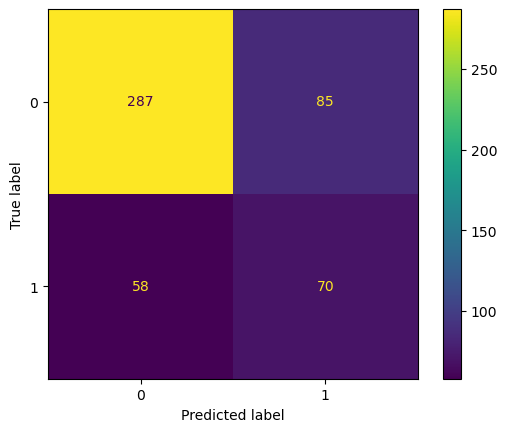

In [ ]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_2.classes_)
disp.plot()
plt.show()

**Confusion Matrix - Model 3 (XGBoost)**

In [ ]:
# Confusion matrix - training set
cm_train = confusion_matrix(y_train_balanced, model_3.predict(X_OHE_train_balanced))
tn_train, fp_train, fn_train, tp_train = cm_train.ravel()
display(cm_train)
print(classification_report(y_train_balanced, model_3.predict(X_OHE_train_balanced)))

array([[3938, 1062],
       [ 926, 4074]])

              precision    recall  f1-score   support

           0       0.81      0.79      0.80      5000
           1       0.79      0.81      0.80      5000

    accuracy                           0.80     10000
   macro avg       0.80      0.80      0.80     10000
weighted avg       0.80      0.80      0.80     10000



In [ ]:
# Confusion matrix - test set
cm = confusion_matrix(y_test, y_pred_balanced_3)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_balanced_3).ravel()
print(classification_report(y_test, y_pred_balanced_3))
print(precision_score(y_test, y_pred_balanced_3, pos_label=1))
print(recall_score(y_test, y_pred_balanced_3, pos_label=1))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       372
           1       0.45      0.54      0.49       128

    accuracy                           0.71       500
   macro avg       0.64      0.66      0.65       500
weighted avg       0.73      0.71      0.72       500

0.45098039215686275
0.5390625


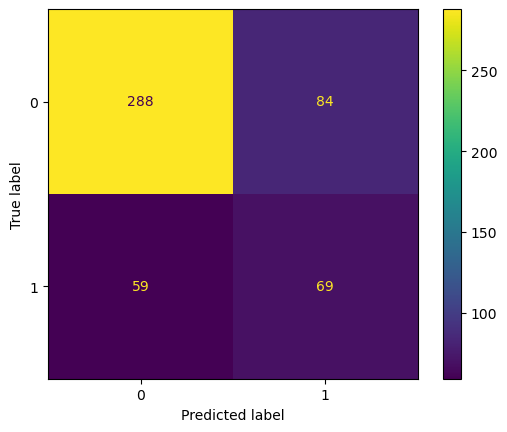

In [ ]:
# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model_3.classes_)
disp.plot()
plt.show()

# 7. Summary of the results

The following table summarises the model performance of each model shown in section 6. Since there are four sections and each of them contains three models, there are 12 models in total.

Note: there is a typo in the name of the models. They should have been called 6A, 6B, etc., since they are trained and shown in section 6.

In [ ]:
model_name = 'xgboost_8D_synthetic'
history[model_name] = {
    'accuracy' : accuracy_score(y_test, y_pred_balanced_3),
    'precision' : precision_score(y_test, y_pred_balanced_3, pos_label=1),
    'recall' : recall_score(y_test, y_pred_balanced_3, pos_label=1),   
    'f1-score' : f1_score(y_test, y_pred_balanced_3, pos_label=1)
}

In [ ]:
pd.DataFrame.from_dict(history).T

,accuracy,precision,recall,f1-score
logistic_regression_8A,0.740,0.466667,0.109375,0.177215
random_forest_8A,0.756,0.650000,0.101562,0.175676
xgboost_8A,0.706,0.373333,0.218750,0.275862
logistic_regression_8B,0.746,0.513514,0.148438,0.230303
random_forest_8B,0.744,0.500000,0.164062,0.247059
xgboost_8B,0.724,0.419355,0.203125,0.273684
logistic_regression_8C,0.754,0.575758,0.148438,0.236025
random_forest_8C,0.754,0.564103,0.171875,0.263473
xgboost_8C,0.766,0.622222,0.218750,0.323699
logistic_regression_8D_synthetic,0.706,0.435374,0.500000,0.465455


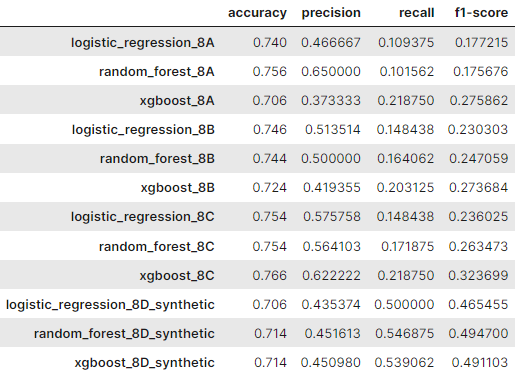

# 8. Conclusion

As shown in section 6, the XGBoost model scores significantly higher on virtually all metrics, especially when considering its average F1 score. Therefore, despite the fact that the results were very similar across the 3 models, the following analysis uses the results from the XGBoost to aim to prove the two hypotheses.

The first hypothesis is that synthetic data can enhance classifier performance by increasing the amount of data available. From the model performances in section 6, we can observe that the model trained with 10000 rows of synthetic data yield better performance metrics, as it resulted in a higher model accuracy, but was also able to minimise False Negatives and Positives with a higher F1 score. Besides helping hotels predicting cancellations, in practice, this can help the hospitality industry by possibly allowing the analysis of specific customer segments. For instance, in city-based hotels, the proportion of business customers tends to be much higher than the share of leaire customer. Hence, if the company aims to analyse the latter customer segment, synthetic data can be used to train models with higher expected model performance. Moreover, from a more generic perspective, the use of synthetic data can also be applied to train algorithms where there is a need of significant amount of labeled training data. For instance, when the model involves deep learning.

Secondly, we aim to prove that synthetic data can also enhance classifiers performance in unbalanced data. In section 6.4, we balance the classes to have the same number of entries for both arriving and non-arriving customers. We find that the model trained on balanced data yields higher recall and overall F1 score, although it falls behind in accuracy and precision. Overall, there is a cost minimisation tradeoff. In the case of predicting non-arriving customers, our aim is to minimise the total cost (including the lost revenues and the overbooking costs). With this said, we can say that the second hypothesis is true as the F1 score is higher in the model trained with balanced classes. Nonetheless, it is important to note that in the hospitality industry, the average overbooking cost is usually higher than the lost revenue. In this case, the lost revenue is understood as a the cost incurred by the hotel if the customer falls under a False Negative, while the overbooking cost is the cost incurred in the False Positive region. Hence, if our objective is to minimise the overbooking cost, the model trained with imbalanced data performs better as the precision score is higher, and therefore, the second hypothesis would be false.

In conclusion, we can confirm that the generation of synthetic data is useful to train classifier models by increasing the total amount of data available. However, whether synthetic data should be used to balance classes in a classification task depends on the weight of the False Negatives and a False Positives. As an extension, cost matrices can be developed to decide the thresholds of incorrect prediction the company can afford, and deliver the best output possible.

# 9. Authors

This notebook was originally created by:
- MUHAMMAD UMAR FATHURROHMAN
- MANUEL CHABIER ESCOLA PEREZ
- VIREN AJAY PRADAN ADWANI

Copyright 2023 ©

# 10. References

Antonio, N., De Almeida, A. & Nunes, L. (2017). Predicting Hotel Bookings Cancellation with a Machine Learning Classification Model. 1049-1054.

Brownlee, J. (2019, December 23). A Gentle Introduction to Imbalanced Classification. Machine Learning Mastery. Available at https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/.

K. T. Talluri, G. J. van Ryzin, I. Z. Karaesmen and G. J. Vulcano, "Revenue management: Models and methods," 2008 Winter Simulation Conference, Miami, FL, USA, 2008, pp. 145-156, doi: 10.1109/WSC.2008.4736064.

Hayes, D.K., Hayes, J.D., & Miller, P.A. (2011). Revenue Management for the Hospitality Industry. Hoboken, NJ: John Wiley & Sons.

Van Ryzin, G. J., & Talluri, K. T. (2014). An Introduction to Revenue Management. INFORMS Transactions on Education, 14(1), 1-8. doi: 10.1287/educ.1053.0019.

Xu, L., Skoularidou, M., Cuesta-Infante, A., & Veeramachaneni, K. (2019). Modeling Tabular Data Using Conditional GAN. Proceedings of the 33rd International Conference on Neural Information Processing Systems (p. 11). New York: Curran Associates Inc.